# Image Classification
# Using Convolutional Neural Network
##  By Yosry Negm

### About the project 

This deep learning project is all about developing an Image classification algorithm that could be used as part of a mobile or web app.  At the end of this project, the code accepts any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.

### Contents

* [Step 0](#step0): Importing Datasets
* [Step 1](#step1): Detecting Humans
* [Step 2](#step2): Detecting Dogs
* [Step 3](#step3): Creating a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Using a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Creating a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Writing the Algorithm
* [Step 7](#step7): Testing the Algorithm

<hr/>
## <font color='gray'>Some Custom Settings</font>

In [1]:
# to hide warenings (after finishing the project for neat output)
import warnings
warnings.filterwarnings('ignore')

<hr/>

<a id='step0'></a>
## Step 0: Importing Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [2]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detecting Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


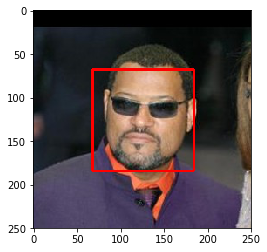

In [4]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,0,255),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [5]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### Assess the Human Face Detector

The code cell below to test the performance of the `face_detector` function and give answer to the following:-  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [6]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

Vectorizefaces = np.vectorize(face_detector)
human_faces = Vectorizefaces(human_files_short)
dog_faces = Vectorizefaces(dog_files_short)

# printing the percentage of detected faces in the sample short datasets
print('------------------ Test of performance ------------------------\n' )
print('{:.2f}% of short human dataset are detected as human faces.'.format((sum(human_faces)/len(human_faces))*100))
print('{:.2f}% of short dog dataset are detected as human faces.'.format((sum(dog_faces)/len(dog_faces))*100))

------------------ Test of performance ------------------------

99.00% of short human dataset are detected as human faces.
12.00% of short dog dataset are detected as human faces.


So we note that :<br>
- <font color='green'>99 % </font>of short <u>human dataset</u> are detected as human faces.
- <font color='red'>12 % </font>of short <u>dog dataset</u> are detected as human faces.

This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). We may ask, is this a reasonable expectation to pose on the user? If not, can we think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

and the answer to this could be as follows:-

From the above results, it looks like there is <b>imprefect</b> performance (12 % in dogs sample are detected wrongly as human) 
And In my opinion,<b>we should not ask users in real-life applications to provide images of clear view of the faces</b>( maybe we could make hint for him for that but not force him to do).However,<b>we couldn't blame on the system</b> in this case but in our pervious using of OpenCV (HAAR Cascades) for face detection, I think that 
the algorithm works in <b>ideal situations </b>of clear images and well prepared photos(since Haar features are good at detecting frontal faces and not so good for detecting profile faces).
to solve this issue we could build the face detection algorithm using Convolutional Neural Networks (<b>CNN</b>),then train it well over large volume of different images to gain acceptable high performance and this method will be cost time and hardware . So, I suggest to contine use OpenCV Haar Cascades methods for simplicity and its performance is some how could be accepted and it is most common one to be used.<br>
Below I've tried to use LBP (Local Binary Patterns Classifier) for face detection ,it is <b>faster</b> than Haar Cascades but <b>less accurate</b>.

In [7]:

# pre-trained  LBP  

lbp_FaceCascade = cv2.CascadeClassifier('lbp/lbpcascade_frontalface.xml')

# Defining a function to detect face using LBP (Local Binary Patterns Classifier)
# returns "True" if face is detected in image stored at img_path

def LBP(path_to_image):
    img = cv2.imread(path_to_image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = lbp_FaceCascade.detectMultiScale(gray)
    return len(faces) > 0

In [8]:
# Vectorize the detection function

Vectorizefaces2 = np.vectorize(LBP)

Number of faces detected: 1


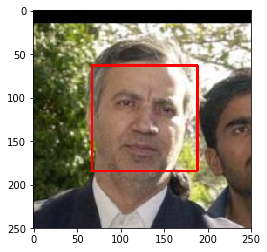

In [9]:
# LBP 
img2 = cv2.imread(human_files[13])
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
faces2 = lbp_FaceCascade.detectMultiScale(gray2)
print('Number of faces detected:', len(faces))
for (x,y,w,h) in faces2:
    cv2.rectangle(img2,(x,y),(x+w,y+h),(0,0,255),2)
cv_rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb2)
plt.show()

In [10]:
# Test LBP

human_faces2 = Vectorizefaces2(human_files_short)
dog_faces2 = Vectorizefaces2(dog_files_short)

# printing the percentage of detected faces in the sample short datasets

print('------------------ Alternative Algorithm (LBP) Test of performance ------------------------\n' )
print('{:.2f}% of short human dataset are detected as human faces.'.format((sum(human_faces2)/len(human_faces2))*100))
print('{:.2f}% of short dog dataset are detected as human faces.'.format((sum(dog_faces2)/len(dog_faces2))*100))


------------------ Alternative Algorithm (LBP) Test of performance ------------------------

98.00% of short human dataset are detected as human faces.
25.00% of short dog dataset are detected as human faces.


---
<a id='step2'></a>
## Step 2: Detecting Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [11]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in our dataset!

In [12]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [13]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [14]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

The code below tests the performance of our `dog_detector` function and aswers the following questions:- 
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

So that the answer will be:-

- <font color='green'>1 % </font>of short <u>human dataset</u> are detected as dog faces.
- <font color='green'>100 % </font>of short <u>dog dataset</u> are detected as dog faces.

In [15]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.


# Vectorize ResNet50 detection function

Vectorizefaces3 = np.vectorize(dog_detector)

# Test the ResNet50 face detector   

human_faces3 = Vectorizefaces3(human_files_short)
dog_faces3 = Vectorizefaces3(dog_files_short)

# printing the percentage of detected faces in the sample short datasets

print('------------------ ResNet50 Test of performance ------------------------\n' )
print('{:.2f}% of short human dataset are detected as faces.'.format((sum(human_faces3)/len(human_faces3))*100))
print('{:.2f}% of short dog dataset are detected as faces.'.format((sum(dog_faces3)/len(dog_faces3))*100))



------------------ ResNet50 Test of performance ------------------------

1.00% of short human dataset are detected as faces.
100.00% of short dog dataset are detected as faces.


---
<a id='step3'></a>
## Step 3: Creating a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  we must create our CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this project, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for our algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  it all depends on Experimenting with many different architectures, and trust our intuition.

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [18]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 836/836 [00:23<00:00, 34.92it/s]


In [19]:
print('------------------ Tesnors dimensions ------------------------\n' )
print ("Train Tensors Size : ")
print (np.shape(train_tensors))
print ("Valid Tensors Size : ")
print (np.shape(valid_tensors))
print ("Test Tensors Size : ")
print (np.shape(test_tensors))

------------------ Tesnors dimensions ------------------------

Train Tensors Size : 
(6680, 224, 224, 3)
Valid Tensors Size : 
(835, 224, 224, 3)
Test Tensors Size : 
(836, 224, 224, 3)


### Model Architecture

It is obvious from the results of the following model performance that the proposed CNN architecture works well for the image classification task. Generally, when come to image classification problems we know that traditional fully-connected neural networks don’t perfom well because they are not cabable of handling large number of connections. CNN networks improve the efficiency of deep neural networks this is clear since large pictures that are millions of pixels in size . For traditional neural network it will model them using matrix multiplication operations that involve every input and every parameter which results easily in tens of billions of computations but CNN  based on convolution operations between and input and a kernel tensors tends to be drastically smaller than the input which simplifies the number of computations required to train the model or to make predictions focuing on relevant features leads to fewer parameters and hence  more efficient<b> Sparse Representations</b>.As well as <b>Parameter Sharing</b> i.e. reuse the same parameters across different functions in the deep neural network which reflects back on massive savings in memory compared to traditional models.<br>
For the hinted architecture,I have made some changes in it to get enhanced Feature Extraction (one more layer of Convolution Filters were added ), Also I Changed the size of window of First MaxPool layer in order to allow the model to generalize better, As well as putting dropout layers to avoid overfitting. 

I will create a CNN to classify dog breed.  At the end of the code , I will summarize the layers of our model by executing the line:
    
        model.summary()

For more practice, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)      

## Building the model

In [20]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Define your architecture.

model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu',input_shape=(train_tensors.shape[1:]) ))
model.add(MaxPooling2D(pool_size=3))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(GlobalAveragePooling2D(data_format=None))
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)       32896     
__________

### Compile the Model

In [21]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

The following code explains the training of our model.  we are using model checkpointing to save the model that attains the best validation loss.

for more explainations you could visit the link [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [22]:
from keras.callbacks import ModelCheckpoint  

### specify the number of epochs that you would like to use to train the model.

epochs = 50



checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/50
4040/6680 [=================>............] - ETA: 31:43 - loss: 4.9023 - acc: 0.0000e+ - ETA: 17:12 - loss: 4.9070 - acc: 0.0000e+ - ETA: 12:20 - loss: 4.9017 - acc: 0.0000e+ - ETA: 9:54 - loss: 4.8966 - acc: 0.0000e+00 - ETA: 8:26 - loss: 4.8976 - acc: 0.0000e+0 - ETA: 7:27 - loss: 4.8967 - acc: 0.0000e+0 - ETA: 6:44 - loss: 4.8987 - acc: 0.0071    - ETA: 6:12 - loss: 4.8994 - acc: 0.006 - ETA: 5:48 - loss: 4.8977 - acc: 0.005 - ETA: 5:28 - loss: 4.8967 - acc: 0.005 - ETA: 5:12 - loss: 4.8964 - acc: 0.004 - ETA: 4:58 - loss: 4.8958 - acc: 0.008 - ETA: 4:46 - loss: 4.8946 - acc: 0.007 - ETA: 4:36 - loss: 4.8940 - acc: 0.007 - ETA: 4:27 - loss: 4.8940 - acc: 0.006 - ETA: 4:19 - loss: 4.8939 - acc: 0.006 - ETA: 4:13 - loss: 4.8930 - acc: 0.005 - ETA: 4:06 - loss: 4.8935 - acc: 0.005 - ETA: 4:01 - loss: 4.8934 - acc: 0.007 - ETA: 3:56 - loss: 4.8931 - acc: 0.007 - ETA: 3:51 - loss: 4.8922 - acc: 0.007 - ETA: 3:47 - loss: 4.8911 - a

4080/6680 [=================>............] - ETA: 2:52 - loss: 4.8812 - acc: 0.0000e+0 - ETA: 2:49 - loss: 4.8351 - acc: 0.0250    - ETA: 2:45 - loss: 4.8098 - acc: 0.016 - ETA: 2:42 - loss: 4.8269 - acc: 0.012 - ETA: 2:41 - loss: 4.8204 - acc: 0.010 - ETA: 2:40 - loss: 4.8235 - acc: 0.008 - ETA: 2:40 - loss: 4.8426 - acc: 0.007 - ETA: 2:39 - loss: 4.8457 - acc: 0.006 - ETA: 2:39 - loss: 4.8377 - acc: 0.011 - ETA: 2:38 - loss: 4.8391 - acc: 0.015 - ETA: 2:37 - loss: 4.8336 - acc: 0.013 - ETA: 2:36 - loss: 4.8383 - acc: 0.012 - ETA: 2:36 - loss: 4.8349 - acc: 0.015 - ETA: 2:35 - loss: 4.8346 - acc: 0.014 - ETA: 2:34 - loss: 4.8335 - acc: 0.013 - ETA: 2:34 - loss: 4.8347 - acc: 0.012 - ETA: 2:34 - loss: 4.8367 - acc: 0.011 - ETA: 2:34 - loss: 4.8389 - acc: 0.011 - ETA: 2:34 - loss: 4.8414 - acc: 0.010 - ETA: 2:34 - loss: 4.8424 - acc: 0.010 - ETA: 2:33 - loss: 4.8420 - acc: 0.011 - ETA: 2:33 - loss: 4.8432 - acc: 0.011 - ETA: 2:33 - loss: 4.8369 - acc: 0.010 - ETA: 2:32 - loss: 4.8323 - 

6680/6680 [==============================] - ETA: 1:04 - loss: 4.8294 - acc: 0.012 - ETA: 1:04 - loss: 4.8296 - acc: 0.012 - ETA: 1:03 - loss: 4.8304 - acc: 0.012 - ETA: 1:03 - loss: 4.8308 - acc: 0.012 - ETA: 1:02 - loss: 4.8310 - acc: 0.012 - ETA: 1:02 - loss: 4.8313 - acc: 0.012 - ETA: 1:01 - loss: 4.8312 - acc: 0.013 - ETA: 1:01 - loss: 4.8312 - acc: 0.013 - ETA: 1:00 - loss: 4.8310 - acc: 0.012 - ETA: 1:00 - loss: 4.8307 - acc: 0.012 - ETA: 59s - loss: 4.8301 - acc: 0.012 - ETA: 59s - loss: 4.8306 - acc: 0.01 - ETA: 58s - loss: 4.8305 - acc: 0.01 - ETA: 58s - loss: 4.8304 - acc: 0.01 - ETA: 57s - loss: 4.8298 - acc: 0.01 - ETA: 57s - loss: 4.8296 - acc: 0.01 - ETA: 56s - loss: 4.8291 - acc: 0.01 - ETA: 56s - loss: 4.8294 - acc: 0.01 - ETA: 55s - loss: 4.8294 - acc: 0.01 - ETA: 55s - loss: 4.8290 - acc: 0.01 - ETA: 54s - loss: 4.8284 - acc: 0.01 - ETA: 54s - loss: 4.8290 - acc: 0.01 - ETA: 53s - loss: 4.8290 - acc: 0.01 - ETA: 53s - loss: 4.8289 - acc: 0.01 - ETA: 52s - loss: 4.828

4080/6680 [=================>............] - ETA: 2:47 - loss: 4.9760 - acc: 0.0000e+0 - ETA: 2:51 - loss: 4.9149 - acc: 0.0000e+0 - ETA: 2:49 - loss: 4.8322 - acc: 0.0167    - ETA: 2:50 - loss: 4.8007 - acc: 0.025 - ETA: 2:51 - loss: 4.7876 - acc: 0.030 - ETA: 2:50 - loss: 4.7821 - acc: 0.025 - ETA: 2:50 - loss: 4.7761 - acc: 0.028 - ETA: 2:49 - loss: 4.7628 - acc: 0.025 - ETA: 2:49 - loss: 4.7637 - acc: 0.022 - ETA: 2:48 - loss: 4.7670 - acc: 0.020 - ETA: 2:48 - loss: 4.7609 - acc: 0.018 - ETA: 2:47 - loss: 4.7565 - acc: 0.016 - ETA: 2:46 - loss: 4.7589 - acc: 0.015 - ETA: 2:46 - loss: 4.7559 - acc: 0.017 - ETA: 2:45 - loss: 4.7444 - acc: 0.020 - ETA: 2:45 - loss: 4.7455 - acc: 0.021 - ETA: 2:44 - loss: 4.7353 - acc: 0.023 - ETA: 2:44 - loss: 4.7364 - acc: 0.025 - ETA: 2:44 - loss: 4.7454 - acc: 0.023 - ETA: 2:43 - loss: 4.7404 - acc: 0.025 - ETA: 2:42 - loss: 4.7360 - acc: 0.023 - ETA: 2:41 - loss: 4.7228 - acc: 0.025 - ETA: 2:40 - loss: 4.7236 - acc: 0.023 - ETA: 2:40 - loss: 4.735

6680/6680 [==============================] - ETA: 1:04 - loss: 4.6961 - acc: 0.027 - ETA: 1:04 - loss: 4.6958 - acc: 0.028 - ETA: 1:03 - loss: 4.6963 - acc: 0.028 - ETA: 1:03 - loss: 4.6960 - acc: 0.028 - ETA: 1:02 - loss: 4.6958 - acc: 0.028 - ETA: 1:02 - loss: 4.6959 - acc: 0.028 - ETA: 1:01 - loss: 4.6959 - acc: 0.028 - ETA: 1:01 - loss: 4.6955 - acc: 0.028 - ETA: 1:00 - loss: 4.6965 - acc: 0.028 - ETA: 1:00 - loss: 4.6964 - acc: 0.028 - ETA: 59s - loss: 4.6960 - acc: 0.028 - ETA: 59s - loss: 4.6961 - acc: 0.02 - ETA: 58s - loss: 4.6954 - acc: 0.02 - ETA: 58s - loss: 4.6945 - acc: 0.02 - ETA: 57s - loss: 4.6938 - acc: 0.02 - ETA: 57s - loss: 4.6941 - acc: 0.02 - ETA: 56s - loss: 4.6960 - acc: 0.02 - ETA: 56s - loss: 4.6951 - acc: 0.02 - ETA: 55s - loss: 4.6958 - acc: 0.02 - ETA: 55s - loss: 4.6954 - acc: 0.02 - ETA: 54s - loss: 4.6961 - acc: 0.02 - ETA: 54s - loss: 4.6966 - acc: 0.02 - ETA: 53s - loss: 4.6977 - acc: 0.02 - ETA: 53s - loss: 4.6975 - acc: 0.02 - ETA: 52s - loss: 4.697

4080/6680 [=================>............] - ETA: 2:47 - loss: 4.5982 - acc: 0.100 - ETA: 2:41 - loss: 4.5329 - acc: 0.100 - ETA: 2:37 - loss: 4.5341 - acc: 0.066 - ETA: 2:37 - loss: 4.5647 - acc: 0.062 - ETA: 2:38 - loss: 4.5264 - acc: 0.050 - ETA: 2:39 - loss: 4.5769 - acc: 0.050 - ETA: 2:39 - loss: 4.5767 - acc: 0.042 - ETA: 2:39 - loss: 4.5836 - acc: 0.043 - ETA: 2:39 - loss: 4.5627 - acc: 0.038 - ETA: 2:39 - loss: 4.5303 - acc: 0.050 - ETA: 2:38 - loss: 4.5356 - acc: 0.050 - ETA: 2:38 - loss: 4.5365 - acc: 0.050 - ETA: 2:38 - loss: 4.5493 - acc: 0.050 - ETA: 2:38 - loss: 4.5178 - acc: 0.053 - ETA: 2:38 - loss: 4.5039 - acc: 0.056 - ETA: 2:37 - loss: 4.4942 - acc: 0.053 - ETA: 2:37 - loss: 4.5129 - acc: 0.052 - ETA: 2:36 - loss: 4.5108 - acc: 0.055 - ETA: 2:36 - loss: 4.5110 - acc: 0.055 - ETA: 2:35 - loss: 4.5135 - acc: 0.052 - ETA: 2:35 - loss: 4.5174 - acc: 0.050 - ETA: 2:34 - loss: 4.5186 - acc: 0.047 - ETA: 2:34 - loss: 4.5307 - acc: 0.045 - ETA: 2:34 - loss: 4.5211 - acc: 0.0

6680/6680 [==============================] - ETA: 1:04 - loss: 4.5298 - acc: 0.046 - ETA: 1:04 - loss: 4.5288 - acc: 0.046 - ETA: 1:03 - loss: 4.5288 - acc: 0.046 - ETA: 1:03 - loss: 4.5298 - acc: 0.046 - ETA: 1:02 - loss: 4.5286 - acc: 0.046 - ETA: 1:02 - loss: 4.5283 - acc: 0.046 - ETA: 1:01 - loss: 4.5259 - acc: 0.047 - ETA: 1:01 - loss: 4.5262 - acc: 0.047 - ETA: 1:00 - loss: 4.5264 - acc: 0.047 - ETA: 1:00 - loss: 4.5257 - acc: 0.047 - ETA: 59s - loss: 4.5251 - acc: 0.047 - ETA: 59s - loss: 4.5247 - acc: 0.04 - ETA: 58s - loss: 4.5245 - acc: 0.04 - ETA: 58s - loss: 4.5231 - acc: 0.04 - ETA: 57s - loss: 4.5232 - acc: 0.04 - ETA: 57s - loss: 4.5234 - acc: 0.04 - ETA: 56s - loss: 4.5237 - acc: 0.04 - ETA: 56s - loss: 4.5227 - acc: 0.04 - ETA: 55s - loss: 4.5227 - acc: 0.04 - ETA: 55s - loss: 4.5229 - acc: 0.04 - ETA: 54s - loss: 4.5235 - acc: 0.04 - ETA: 54s - loss: 4.5223 - acc: 0.04 - ETA: 53s - loss: 4.5216 - acc: 0.04 - ETA: 53s - loss: 4.5226 - acc: 0.04 - ETA: 52s - loss: 4.523

4080/6680 [=================>............] - ETA: 2:42 - loss: 4.3289 - acc: 0.150 - ETA: 2:43 - loss: 4.1388 - acc: 0.175 - ETA: 2:42 - loss: 4.2286 - acc: 0.133 - ETA: 2:42 - loss: 4.2143 - acc: 0.150 - ETA: 2:43 - loss: 4.2011 - acc: 0.140 - ETA: 2:43 - loss: 4.1990 - acc: 0.141 - ETA: 2:43 - loss: 4.2628 - acc: 0.121 - ETA: 2:42 - loss: 4.2723 - acc: 0.118 - ETA: 2:41 - loss: 4.2980 - acc: 0.116 - ETA: 2:42 - loss: 4.3056 - acc: 0.105 - ETA: 2:41 - loss: 4.3219 - acc: 0.100 - ETA: 2:41 - loss: 4.3089 - acc: 0.091 - ETA: 2:40 - loss: 4.2881 - acc: 0.103 - ETA: 2:39 - loss: 4.2758 - acc: 0.103 - ETA: 2:39 - loss: 4.2939 - acc: 0.100 - ETA: 2:39 - loss: 4.2746 - acc: 0.100 - ETA: 2:38 - loss: 4.2897 - acc: 0.097 - ETA: 2:38 - loss: 4.2801 - acc: 0.094 - ETA: 2:37 - loss: 4.2682 - acc: 0.094 - ETA: 2:37 - loss: 4.2955 - acc: 0.090 - ETA: 2:37 - loss: 4.2921 - acc: 0.088 - ETA: 2:36 - loss: 4.2946 - acc: 0.088 - ETA: 2:36 - loss: 4.3168 - acc: 0.084 - ETA: 2:35 - loss: 4.3324 - acc: 0.0

6680/6680 [==============================] - ETA: 1:04 - loss: 4.3529 - acc: 0.062 - ETA: 1:04 - loss: 4.3523 - acc: 0.061 - ETA: 1:03 - loss: 4.3534 - acc: 0.061 - ETA: 1:03 - loss: 4.3532 - acc: 0.061 - ETA: 1:02 - loss: 4.3531 - acc: 0.061 - ETA: 1:02 - loss: 4.3534 - acc: 0.061 - ETA: 1:01 - loss: 4.3539 - acc: 0.060 - ETA: 1:01 - loss: 4.3520 - acc: 0.061 - ETA: 1:00 - loss: 4.3516 - acc: 0.061 - ETA: 1:00 - loss: 4.3496 - acc: 0.062 - ETA: 59s - loss: 4.3494 - acc: 0.062 - ETA: 59s - loss: 4.3515 - acc: 0.06 - ETA: 58s - loss: 4.3521 - acc: 0.06 - ETA: 58s - loss: 4.3515 - acc: 0.06 - ETA: 57s - loss: 4.3516 - acc: 0.06 - ETA: 57s - loss: 4.3512 - acc: 0.06 - ETA: 56s - loss: 4.3506 - acc: 0.06 - ETA: 56s - loss: 4.3506 - acc: 0.06 - ETA: 55s - loss: 4.3517 - acc: 0.06 - ETA: 55s - loss: 4.3503 - acc: 0.06 - ETA: 54s - loss: 4.3502 - acc: 0.06 - ETA: 54s - loss: 4.3508 - acc: 0.06 - ETA: 53s - loss: 4.3509 - acc: 0.06 - ETA: 53s - loss: 4.3504 - acc: 0.06 - ETA: 52s - loss: 4.351

4080/6680 [=================>............] - ETA: 2:52 - loss: 4.3324 - acc: 0.0000e+0 - ETA: 2:45 - loss: 4.0348 - acc: 0.1000    - ETA: 2:39 - loss: 4.2665 - acc: 0.066 - ETA: 2:37 - loss: 4.2910 - acc: 0.062 - ETA: 2:37 - loss: 4.2209 - acc: 0.060 - ETA: 2:36 - loss: 4.2006 - acc: 0.066 - ETA: 2:37 - loss: 4.1593 - acc: 0.071 - ETA: 2:38 - loss: 4.1659 - acc: 0.062 - ETA: 2:38 - loss: 4.1618 - acc: 0.061 - ETA: 2:38 - loss: 4.2089 - acc: 0.060 - ETA: 2:38 - loss: 4.2054 - acc: 0.054 - ETA: 2:38 - loss: 4.2144 - acc: 0.050 - ETA: 2:38 - loss: 4.2290 - acc: 0.046 - ETA: 2:37 - loss: 4.1974 - acc: 0.050 - ETA: 2:37 - loss: 4.1596 - acc: 0.063 - ETA: 2:37 - loss: 4.1822 - acc: 0.059 - ETA: 2:37 - loss: 4.2019 - acc: 0.055 - ETA: 2:37 - loss: 4.2077 - acc: 0.058 - ETA: 2:37 - loss: 4.2043 - acc: 0.055 - ETA: 2:36 - loss: 4.2101 - acc: 0.052 - ETA: 2:35 - loss: 4.2228 - acc: 0.054 - ETA: 2:35 - loss: 4.2336 - acc: 0.056 - ETA: 2:35 - loss: 4.2362 - acc: 0.058 - ETA: 2:34 - loss: 4.2412 - 

6680/6680 [==============================] - ETA: 1:05 - loss: 4.2193 - acc: 0.072 - ETA: 1:05 - loss: 4.2171 - acc: 0.072 - ETA: 1:04 - loss: 4.2154 - acc: 0.072 - ETA: 1:03 - loss: 4.2146 - acc: 0.072 - ETA: 1:03 - loss: 4.2131 - acc: 0.073 - ETA: 1:02 - loss: 4.2107 - acc: 0.073 - ETA: 1:02 - loss: 4.2117 - acc: 0.073 - ETA: 1:01 - loss: 4.2107 - acc: 0.073 - ETA: 1:01 - loss: 4.2110 - acc: 0.073 - ETA: 1:00 - loss: 4.2127 - acc: 0.073 - ETA: 1:00 - loss: 4.2133 - acc: 0.073 - ETA: 59s - loss: 4.2130 - acc: 0.073 - ETA: 59s - loss: 4.2144 - acc: 0.07 - ETA: 58s - loss: 4.2141 - acc: 0.07 - ETA: 58s - loss: 4.2152 - acc: 0.07 - ETA: 57s - loss: 4.2145 - acc: 0.07 - ETA: 57s - loss: 4.2130 - acc: 0.07 - ETA: 56s - loss: 4.2115 - acc: 0.07 - ETA: 56s - loss: 4.2120 - acc: 0.07 - ETA: 55s - loss: 4.2119 - acc: 0.07 - ETA: 55s - loss: 4.2119 - acc: 0.07 - ETA: 54s - loss: 4.2119 - acc: 0.07 - ETA: 54s - loss: 4.2121 - acc: 0.07 - ETA: 53s - loss: 4.2094 - acc: 0.07 - ETA: 53s - loss: 4.2

4080/6680 [=================>............] - ETA: 2:36 - loss: 3.8040 - acc: 0.250 - ETA: 2:41 - loss: 3.9610 - acc: 0.200 - ETA: 2:40 - loss: 4.0424 - acc: 0.183 - ETA: 2:42 - loss: 4.0929 - acc: 0.162 - ETA: 2:43 - loss: 4.0595 - acc: 0.150 - ETA: 2:43 - loss: 4.0507 - acc: 0.133 - ETA: 2:44 - loss: 4.0783 - acc: 0.128 - ETA: 2:43 - loss: 4.0269 - acc: 0.137 - ETA: 2:42 - loss: 4.0676 - acc: 0.122 - ETA: 2:42 - loss: 4.0913 - acc: 0.110 - ETA: 2:42 - loss: 4.0819 - acc: 0.109 - ETA: 2:42 - loss: 4.0987 - acc: 0.104 - ETA: 2:42 - loss: 4.1173 - acc: 0.100 - ETA: 2:41 - loss: 4.1003 - acc: 0.103 - ETA: 2:40 - loss: 4.1293 - acc: 0.100 - ETA: 2:40 - loss: 4.1124 - acc: 0.100 - ETA: 2:39 - loss: 4.1044 - acc: 0.102 - ETA: 2:39 - loss: 4.1104 - acc: 0.100 - ETA: 2:38 - loss: 4.1346 - acc: 0.102 - ETA: 2:37 - loss: 4.1157 - acc: 0.105 - ETA: 2:37 - loss: 4.1279 - acc: 0.104 - ETA: 2:36 - loss: 4.1392 - acc: 0.100 - ETA: 2:36 - loss: 4.1331 - acc: 0.097 - ETA: 2:35 - loss: 4.1296 - acc: 0.1

6680/6680 [==============================] - ETA: 1:04 - loss: 4.1109 - acc: 0.081 - ETA: 1:04 - loss: 4.1104 - acc: 0.080 - ETA: 1:03 - loss: 4.1125 - acc: 0.080 - ETA: 1:03 - loss: 4.1112 - acc: 0.081 - ETA: 1:02 - loss: 4.1112 - acc: 0.081 - ETA: 1:02 - loss: 4.1106 - acc: 0.081 - ETA: 1:01 - loss: 4.1116 - acc: 0.081 - ETA: 1:01 - loss: 4.1103 - acc: 0.081 - ETA: 1:00 - loss: 4.1089 - acc: 0.081 - ETA: 1:00 - loss: 4.1103 - acc: 0.081 - ETA: 59s - loss: 4.1099 - acc: 0.081 - ETA: 59s - loss: 4.1084 - acc: 0.08 - ETA: 58s - loss: 4.1089 - acc: 0.08 - ETA: 58s - loss: 4.1076 - acc: 0.08 - ETA: 57s - loss: 4.1068 - acc: 0.08 - ETA: 57s - loss: 4.1047 - acc: 0.08 - ETA: 56s - loss: 4.1055 - acc: 0.08 - ETA: 56s - loss: 4.1069 - acc: 0.08 - ETA: 55s - loss: 4.1066 - acc: 0.08 - ETA: 55s - loss: 4.1052 - acc: 0.08 - ETA: 54s - loss: 4.1066 - acc: 0.08 - ETA: 54s - loss: 4.1075 - acc: 0.08 - ETA: 53s - loss: 4.1065 - acc: 0.08 - ETA: 53s - loss: 4.1063 - acc: 0.08 - ETA: 52s - loss: 4.107

4080/6680 [=================>............] - ETA: 2:46 - loss: 3.9064 - acc: 0.200 - ETA: 2:46 - loss: 3.9204 - acc: 0.125 - ETA: 2:45 - loss: 3.8343 - acc: 0.133 - ETA: 2:44 - loss: 3.9000 - acc: 0.112 - ETA: 2:45 - loss: 3.9845 - acc: 0.100 - ETA: 2:45 - loss: 3.9987 - acc: 0.091 - ETA: 2:44 - loss: 3.9629 - acc: 0.092 - ETA: 2:44 - loss: 3.9921 - acc: 0.093 - ETA: 2:43 - loss: 4.0128 - acc: 0.100 - ETA: 2:43 - loss: 4.0148 - acc: 0.105 - ETA: 2:42 - loss: 3.9875 - acc: 0.104 - ETA: 2:42 - loss: 3.9719 - acc: 0.104 - ETA: 2:41 - loss: 3.9869 - acc: 0.096 - ETA: 2:41 - loss: 3.9964 - acc: 0.092 - ETA: 2:40 - loss: 3.9717 - acc: 0.096 - ETA: 2:40 - loss: 3.9689 - acc: 0.103 - ETA: 2:39 - loss: 3.9688 - acc: 0.100 - ETA: 2:39 - loss: 3.9749 - acc: 0.094 - ETA: 2:38 - loss: 3.9716 - acc: 0.092 - ETA: 2:38 - loss: 3.9606 - acc: 0.095 - ETA: 2:37 - loss: 3.9998 - acc: 0.090 - ETA: 2:36 - loss: 4.0082 - acc: 0.088 - ETA: 2:36 - loss: 4.0103 - acc: 0.087 - ETA: 2:35 - loss: 3.9904 - acc: 0.0

6680/6680 [==============================] - ETA: 1:05 - loss: 4.0051 - acc: 0.097 - ETA: 1:04 - loss: 4.0051 - acc: 0.096 - ETA: 1:04 - loss: 4.0063 - acc: 0.096 - ETA: 1:03 - loss: 4.0058 - acc: 0.096 - ETA: 1:03 - loss: 4.0040 - acc: 0.097 - ETA: 1:02 - loss: 4.0072 - acc: 0.096 - ETA: 1:02 - loss: 4.0082 - acc: 0.096 - ETA: 1:01 - loss: 4.0085 - acc: 0.096 - ETA: 1:01 - loss: 4.0070 - acc: 0.097 - ETA: 1:00 - loss: 4.0082 - acc: 0.096 - ETA: 1:00 - loss: 4.0084 - acc: 0.096 - ETA: 59s - loss: 4.0074 - acc: 0.096 - ETA: 59s - loss: 4.0051 - acc: 0.09 - ETA: 58s - loss: 4.0059 - acc: 0.09 - ETA: 58s - loss: 4.0049 - acc: 0.09 - ETA: 57s - loss: 4.0047 - acc: 0.09 - ETA: 56s - loss: 4.0036 - acc: 0.09 - ETA: 56s - loss: 4.0034 - acc: 0.09 - ETA: 55s - loss: 4.0060 - acc: 0.09 - ETA: 55s - loss: 4.0060 - acc: 0.09 - ETA: 54s - loss: 4.0064 - acc: 0.09 - ETA: 54s - loss: 4.0067 - acc: 0.09 - ETA: 53s - loss: 4.0046 - acc: 0.09 - ETA: 53s - loss: 4.0047 - acc: 0.09 - ETA: 52s - loss: 4.0

4080/6680 [=================>............] - ETA: 3:25 - loss: 4.1514 - acc: 0.100 - ETA: 3:05 - loss: 3.9925 - acc: 0.150 - ETA: 2:58 - loss: 3.8873 - acc: 0.183 - ETA: 2:57 - loss: 3.8757 - acc: 0.162 - ETA: 2:54 - loss: 3.8689 - acc: 0.160 - ETA: 2:52 - loss: 3.8623 - acc: 0.141 - ETA: 2:51 - loss: 3.8349 - acc: 0.135 - ETA: 2:50 - loss: 3.8476 - acc: 0.125 - ETA: 2:48 - loss: 3.8719 - acc: 0.122 - ETA: 2:47 - loss: 3.8635 - acc: 0.125 - ETA: 2:47 - loss: 3.8660 - acc: 0.127 - ETA: 2:46 - loss: 3.8755 - acc: 0.129 - ETA: 2:44 - loss: 3.8970 - acc: 0.126 - ETA: 2:44 - loss: 3.8711 - acc: 0.128 - ETA: 2:43 - loss: 3.8587 - acc: 0.136 - ETA: 2:43 - loss: 3.8638 - acc: 0.134 - ETA: 2:42 - loss: 3.8857 - acc: 0.126 - ETA: 2:42 - loss: 3.8785 - acc: 0.125 - ETA: 2:41 - loss: 3.8819 - acc: 0.123 - ETA: 2:40 - loss: 3.8685 - acc: 0.125 - ETA: 2:39 - loss: 3.8816 - acc: 0.123 - ETA: 2:39 - loss: 3.8730 - acc: 0.125 - ETA: 2:38 - loss: 3.8752 - acc: 0.126 - ETA: 2:38 - loss: 3.8772 - acc: 0.1

6680/6680 [==============================] - ETA: 1:05 - loss: 3.9281 - acc: 0.109 - ETA: 1:04 - loss: 3.9285 - acc: 0.109 - ETA: 1:04 - loss: 3.9303 - acc: 0.108 - ETA: 1:03 - loss: 3.9315 - acc: 0.108 - ETA: 1:03 - loss: 3.9300 - acc: 0.108 - ETA: 1:02 - loss: 3.9306 - acc: 0.108 - ETA: 1:02 - loss: 3.9279 - acc: 0.109 - ETA: 1:01 - loss: 3.9323 - acc: 0.109 - ETA: 1:01 - loss: 3.9327 - acc: 0.109 - ETA: 1:00 - loss: 3.9343 - acc: 0.109 - ETA: 1:00 - loss: 3.9330 - acc: 0.109 - ETA: 59s - loss: 3.9312 - acc: 0.109 - ETA: 59s - loss: 3.9309 - acc: 0.10 - ETA: 58s - loss: 3.9293 - acc: 0.10 - ETA: 58s - loss: 3.9297 - acc: 0.10 - ETA: 57s - loss: 3.9282 - acc: 0.10 - ETA: 57s - loss: 3.9287 - acc: 0.10 - ETA: 56s - loss: 3.9296 - acc: 0.10 - ETA: 56s - loss: 3.9276 - acc: 0.11 - ETA: 55s - loss: 3.9285 - acc: 0.11 - ETA: 55s - loss: 3.9279 - acc: 0.11 - ETA: 54s - loss: 3.9280 - acc: 0.11 - ETA: 54s - loss: 3.9284 - acc: 0.11 - ETA: 53s - loss: 3.9295 - acc: 0.10 - ETA: 53s - loss: 3.9

4080/6680 [=================>............] - ETA: 2:45 - loss: 3.8515 - acc: 0.150 - ETA: 2:45 - loss: 3.6710 - acc: 0.200 - ETA: 2:48 - loss: 3.7697 - acc: 0.183 - ETA: 2:46 - loss: 3.7993 - acc: 0.175 - ETA: 2:45 - loss: 3.7977 - acc: 0.160 - ETA: 2:46 - loss: 3.6928 - acc: 0.166 - ETA: 2:45 - loss: 3.7207 - acc: 0.164 - ETA: 2:44 - loss: 3.7176 - acc: 0.162 - ETA: 2:44 - loss: 3.7544 - acc: 0.155 - ETA: 2:43 - loss: 3.6943 - acc: 0.180 - ETA: 2:43 - loss: 3.6612 - acc: 0.181 - ETA: 2:42 - loss: 3.6318 - acc: 0.175 - ETA: 2:41 - loss: 3.6855 - acc: 0.169 - ETA: 2:41 - loss: 3.7051 - acc: 0.160 - ETA: 2:40 - loss: 3.7273 - acc: 0.160 - ETA: 2:40 - loss: 3.7466 - acc: 0.150 - ETA: 2:39 - loss: 3.7541 - acc: 0.144 - ETA: 2:38 - loss: 3.7392 - acc: 0.141 - ETA: 2:38 - loss: 3.7383 - acc: 0.139 - ETA: 2:38 - loss: 3.7484 - acc: 0.135 - ETA: 2:37 - loss: 3.7782 - acc: 0.131 - ETA: 2:37 - loss: 3.7831 - acc: 0.127 - ETA: 2:36 - loss: 3.7885 - acc: 0.128 - ETA: 2:36 - loss: 3.7921 - acc: 0.1

6680/6680 [==============================] - ETA: 1:04 - loss: 3.8416 - acc: 0.121 - ETA: 1:04 - loss: 3.8406 - acc: 0.121 - ETA: 1:03 - loss: 3.8383 - acc: 0.122 - ETA: 1:03 - loss: 3.8396 - acc: 0.121 - ETA: 1:02 - loss: 3.8395 - acc: 0.121 - ETA: 1:02 - loss: 3.8419 - acc: 0.121 - ETA: 1:01 - loss: 3.8439 - acc: 0.120 - ETA: 1:01 - loss: 3.8440 - acc: 0.120 - ETA: 1:00 - loss: 3.8443 - acc: 0.120 - ETA: 1:00 - loss: 3.8442 - acc: 0.120 - ETA: 59s - loss: 3.8446 - acc: 0.119 - ETA: 59s - loss: 3.8431 - acc: 0.12 - ETA: 58s - loss: 3.8410 - acc: 0.12 - ETA: 58s - loss: 3.8420 - acc: 0.12 - ETA: 57s - loss: 3.8434 - acc: 0.12 - ETA: 57s - loss: 3.8440 - acc: 0.12 - ETA: 56s - loss: 3.8432 - acc: 0.12 - ETA: 56s - loss: 3.8448 - acc: 0.11 - ETA: 55s - loss: 3.8453 - acc: 0.11 - ETA: 55s - loss: 3.8462 - acc: 0.11 - ETA: 54s - loss: 3.8442 - acc: 0.11 - ETA: 54s - loss: 3.8447 - acc: 0.11 - ETA: 53s - loss: 3.8458 - acc: 0.11 - ETA: 53s - loss: 3.8452 - acc: 0.11 - ETA: 52s - loss: 3.843

4080/6680 [=================>............] - ETA: 2:34 - loss: 3.5490 - acc: 0.150 - ETA: 2:39 - loss: 3.6753 - acc: 0.125 - ETA: 2:42 - loss: 3.5087 - acc: 0.150 - ETA: 2:43 - loss: 3.5873 - acc: 0.150 - ETA: 2:42 - loss: 3.5867 - acc: 0.140 - ETA: 2:43 - loss: 3.6000 - acc: 0.133 - ETA: 2:42 - loss: 3.6459 - acc: 0.128 - ETA: 2:42 - loss: 3.6957 - acc: 0.112 - ETA: 2:41 - loss: 3.7226 - acc: 0.122 - ETA: 2:41 - loss: 3.7582 - acc: 0.125 - ETA: 2:40 - loss: 3.7562 - acc: 0.122 - ETA: 2:40 - loss: 3.7955 - acc: 0.120 - ETA: 2:40 - loss: 3.7643 - acc: 0.126 - ETA: 2:39 - loss: 3.7248 - acc: 0.132 - ETA: 2:39 - loss: 3.7331 - acc: 0.130 - ETA: 2:39 - loss: 3.7200 - acc: 0.140 - ETA: 2:38 - loss: 3.7273 - acc: 0.135 - ETA: 2:38 - loss: 3.7285 - acc: 0.133 - ETA: 2:37 - loss: 3.7447 - acc: 0.136 - ETA: 2:37 - loss: 3.7716 - acc: 0.132 - ETA: 2:36 - loss: 3.7518 - acc: 0.135 - ETA: 2:36 - loss: 3.7542 - acc: 0.140 - ETA: 2:35 - loss: 3.7639 - acc: 0.139 - ETA: 2:35 - loss: 3.7592 - acc: 0.1

6680/6680 [==============================] - ETA: 1:04 - loss: 3.7348 - acc: 0.136 - ETA: 1:04 - loss: 3.7315 - acc: 0.137 - ETA: 1:03 - loss: 3.7320 - acc: 0.137 - ETA: 1:03 - loss: 3.7321 - acc: 0.137 - ETA: 1:02 - loss: 3.7312 - acc: 0.137 - ETA: 1:02 - loss: 3.7283 - acc: 0.137 - ETA: 1:01 - loss: 3.7293 - acc: 0.137 - ETA: 1:01 - loss: 3.7298 - acc: 0.137 - ETA: 1:00 - loss: 3.7296 - acc: 0.137 - ETA: 1:00 - loss: 3.7294 - acc: 0.137 - ETA: 59s - loss: 3.7294 - acc: 0.137 - ETA: 59s - loss: 3.7296 - acc: 0.13 - ETA: 58s - loss: 3.7298 - acc: 0.13 - ETA: 58s - loss: 3.7279 - acc: 0.13 - ETA: 57s - loss: 3.7253 - acc: 0.13 - ETA: 57s - loss: 3.7250 - acc: 0.13 - ETA: 56s - loss: 3.7257 - acc: 0.13 - ETA: 56s - loss: 3.7260 - acc: 0.13 - ETA: 55s - loss: 3.7267 - acc: 0.13 - ETA: 55s - loss: 3.7288 - acc: 0.13 - ETA: 54s - loss: 3.7277 - acc: 0.13 - ETA: 54s - loss: 3.7280 - acc: 0.13 - ETA: 53s - loss: 3.7289 - acc: 0.13 - ETA: 53s - loss: 3.7277 - acc: 0.13 - ETA: 52s - loss: 3.728

4080/6680 [=================>............] - ETA: 2:42 - loss: 3.7816 - acc: 0.150 - ETA: 2:43 - loss: 3.7988 - acc: 0.150 - ETA: 2:44 - loss: 3.7450 - acc: 0.166 - ETA: 2:44 - loss: 3.7049 - acc: 0.162 - ETA: 2:45 - loss: 3.7235 - acc: 0.150 - ETA: 2:44 - loss: 3.7010 - acc: 0.158 - ETA: 2:44 - loss: 3.6685 - acc: 0.178 - ETA: 2:43 - loss: 3.6258 - acc: 0.175 - ETA: 2:43 - loss: 3.7122 - acc: 0.172 - ETA: 2:43 - loss: 3.7369 - acc: 0.160 - ETA: 2:42 - loss: 3.7134 - acc: 0.159 - ETA: 2:42 - loss: 3.6869 - acc: 0.166 - ETA: 2:41 - loss: 3.6610 - acc: 0.165 - ETA: 2:41 - loss: 3.6888 - acc: 0.160 - ETA: 2:41 - loss: 3.6887 - acc: 0.160 - ETA: 2:40 - loss: 3.6530 - acc: 0.165 - ETA: 2:39 - loss: 3.6643 - acc: 0.167 - ETA: 2:39 - loss: 3.6793 - acc: 0.166 - ETA: 2:38 - loss: 3.6959 - acc: 0.160 - ETA: 2:38 - loss: 3.6839 - acc: 0.162 - ETA: 2:37 - loss: 3.6859 - acc: 0.157 - ETA: 2:37 - loss: 3.7141 - acc: 0.154 - ETA: 2:36 - loss: 3.7132 - acc: 0.150 - ETA: 2:36 - loss: 3.7143 - acc: 0.1

6680/6680 [==============================] - ETA: 1:04 - loss: 3.6807 - acc: 0.142 - ETA: 1:04 - loss: 3.6780 - acc: 0.142 - ETA: 1:03 - loss: 3.6775 - acc: 0.142 - ETA: 1:03 - loss: 3.6749 - acc: 0.143 - ETA: 1:02 - loss: 3.6766 - acc: 0.143 - ETA: 1:02 - loss: 3.6749 - acc: 0.143 - ETA: 1:01 - loss: 3.6730 - acc: 0.143 - ETA: 1:01 - loss: 3.6707 - acc: 0.143 - ETA: 1:00 - loss: 3.6682 - acc: 0.143 - ETA: 1:00 - loss: 3.6684 - acc: 0.143 - ETA: 59s - loss: 3.6673 - acc: 0.143 - ETA: 59s - loss: 3.6654 - acc: 0.14 - ETA: 58s - loss: 3.6643 - acc: 0.14 - ETA: 58s - loss: 3.6653 - acc: 0.14 - ETA: 57s - loss: 3.6662 - acc: 0.14 - ETA: 57s - loss: 3.6666 - acc: 0.14 - ETA: 56s - loss: 3.6689 - acc: 0.14 - ETA: 56s - loss: 3.6674 - acc: 0.14 - ETA: 55s - loss: 3.6663 - acc: 0.14 - ETA: 55s - loss: 3.6657 - acc: 0.14 - ETA: 54s - loss: 3.6670 - acc: 0.14 - ETA: 54s - loss: 3.6662 - acc: 0.14 - ETA: 53s - loss: 3.6671 - acc: 0.14 - ETA: 53s - loss: 3.6674 - acc: 0.14 - ETA: 52s - loss: 3.664

4080/6680 [=================>............] - ETA: 2:48 - loss: 4.0196 - acc: 0.100 - ETA: 2:49 - loss: 3.8852 - acc: 0.075 - ETA: 2:47 - loss: 3.8153 - acc: 0.066 - ETA: 2:49 - loss: 3.7710 - acc: 0.075 - ETA: 2:48 - loss: 3.7036 - acc: 0.110 - ETA: 2:47 - loss: 3.6619 - acc: 0.133 - ETA: 2:46 - loss: 3.6702 - acc: 0.128 - ETA: 2:46 - loss: 3.5951 - acc: 0.131 - ETA: 2:46 - loss: 3.5414 - acc: 0.144 - ETA: 2:46 - loss: 3.5178 - acc: 0.150 - ETA: 2:45 - loss: 3.5305 - acc: 0.150 - ETA: 2:44 - loss: 3.5116 - acc: 0.154 - ETA: 2:43 - loss: 3.5151 - acc: 0.157 - ETA: 2:43 - loss: 3.5153 - acc: 0.157 - ETA: 2:42 - loss: 3.5150 - acc: 0.160 - ETA: 2:42 - loss: 3.5327 - acc: 0.165 - ETA: 2:41 - loss: 3.5237 - acc: 0.170 - ETA: 2:41 - loss: 3.5221 - acc: 0.166 - ETA: 2:40 - loss: 3.5131 - acc: 0.160 - ETA: 2:39 - loss: 3.5146 - acc: 0.160 - ETA: 2:39 - loss: 3.5257 - acc: 0.157 - ETA: 2:39 - loss: 3.5165 - acc: 0.154 - ETA: 2:39 - loss: 3.5135 - acc: 0.154 - ETA: 2:38 - loss: 3.5098 - acc: 0.1

6680/6680 [==============================] - ETA: 1:04 - loss: 3.5931 - acc: 0.153 - ETA: 1:04 - loss: 3.5922 - acc: 0.153 - ETA: 1:03 - loss: 3.5925 - acc: 0.153 - ETA: 1:03 - loss: 3.5970 - acc: 0.153 - ETA: 1:02 - loss: 3.5982 - acc: 0.153 - ETA: 1:02 - loss: 3.5996 - acc: 0.153 - ETA: 1:01 - loss: 3.6008 - acc: 0.153 - ETA: 1:01 - loss: 3.6021 - acc: 0.153 - ETA: 1:00 - loss: 3.6022 - acc: 0.152 - ETA: 1:00 - loss: 3.6031 - acc: 0.152 - ETA: 59s - loss: 3.6020 - acc: 0.153 - ETA: 59s - loss: 3.5994 - acc: 0.15 - ETA: 58s - loss: 3.5991 - acc: 0.15 - ETA: 58s - loss: 3.5984 - acc: 0.15 - ETA: 57s - loss: 3.5977 - acc: 0.15 - ETA: 57s - loss: 3.5978 - acc: 0.15 - ETA: 56s - loss: 3.5957 - acc: 0.15 - ETA: 56s - loss: 3.5965 - acc: 0.15 - ETA: 55s - loss: 3.5964 - acc: 0.15 - ETA: 55s - loss: 3.5946 - acc: 0.15 - ETA: 54s - loss: 3.5920 - acc: 0.15 - ETA: 54s - loss: 3.5917 - acc: 0.15 - ETA: 53s - loss: 3.5902 - acc: 0.15 - ETA: 53s - loss: 3.5886 - acc: 0.15 - ETA: 52s - loss: 3.588

4080/6680 [=================>............] - ETA: 2:50 - loss: 3.4582 - acc: 0.150 - ETA: 2:48 - loss: 3.2406 - acc: 0.200 - ETA: 2:45 - loss: 3.3117 - acc: 0.183 - ETA: 2:45 - loss: 3.1578 - acc: 0.225 - ETA: 2:44 - loss: 3.2567 - acc: 0.200 - ETA: 2:44 - loss: 3.2537 - acc: 0.225 - ETA: 2:43 - loss: 3.2988 - acc: 0.221 - ETA: 2:43 - loss: 3.3022 - acc: 0.200 - ETA: 2:42 - loss: 3.3679 - acc: 0.194 - ETA: 2:41 - loss: 3.3346 - acc: 0.195 - ETA: 2:41 - loss: 3.3596 - acc: 0.186 - ETA: 2:40 - loss: 3.3690 - acc: 0.200 - ETA: 2:40 - loss: 3.4159 - acc: 0.192 - ETA: 2:39 - loss: 3.4223 - acc: 0.189 - ETA: 2:39 - loss: 3.4325 - acc: 0.186 - ETA: 2:39 - loss: 3.4414 - acc: 0.184 - ETA: 2:38 - loss: 3.4644 - acc: 0.176 - ETA: 2:37 - loss: 3.4410 - acc: 0.177 - ETA: 2:37 - loss: 3.4437 - acc: 0.176 - ETA: 2:36 - loss: 3.4483 - acc: 0.175 - ETA: 2:36 - loss: 3.4577 - acc: 0.173 - ETA: 2:36 - loss: 3.4346 - acc: 0.181 - ETA: 2:35 - loss: 3.4565 - acc: 0.176 - ETA: 2:35 - loss: 3.4432 - acc: 0.1

6680/6680 [==============================] - ETA: 1:04 - loss: 3.4945 - acc: 0.173 - ETA: 1:04 - loss: 3.4948 - acc: 0.173 - ETA: 1:03 - loss: 3.4950 - acc: 0.173 - ETA: 1:03 - loss: 3.4926 - acc: 0.174 - ETA: 1:02 - loss: 3.4940 - acc: 0.174 - ETA: 1:02 - loss: 3.4925 - acc: 0.174 - ETA: 1:01 - loss: 3.4900 - acc: 0.174 - ETA: 1:01 - loss: 3.4885 - acc: 0.175 - ETA: 1:00 - loss: 3.4863 - acc: 0.175 - ETA: 1:00 - loss: 3.4870 - acc: 0.175 - ETA: 59s - loss: 3.4884 - acc: 0.175 - ETA: 59s - loss: 3.4893 - acc: 0.17 - ETA: 58s - loss: 3.4910 - acc: 0.17 - ETA: 58s - loss: 3.4907 - acc: 0.17 - ETA: 57s - loss: 3.4916 - acc: 0.17 - ETA: 57s - loss: 3.4918 - acc: 0.17 - ETA: 56s - loss: 3.4907 - acc: 0.17 - ETA: 56s - loss: 3.4927 - acc: 0.17 - ETA: 55s - loss: 3.4910 - acc: 0.17 - ETA: 55s - loss: 3.4907 - acc: 0.17 - ETA: 54s - loss: 3.4921 - acc: 0.17 - ETA: 54s - loss: 3.4923 - acc: 0.17 - ETA: 53s - loss: 3.4920 - acc: 0.17 - ETA: 53s - loss: 3.4913 - acc: 0.17 - ETA: 52s - loss: 3.489

4080/6680 [=================>............] - ETA: 2:46 - loss: 3.2766 - acc: 0.250 - ETA: 2:40 - loss: 3.0966 - acc: 0.275 - ETA: 2:43 - loss: 3.1454 - acc: 0.266 - ETA: 2:43 - loss: 3.2756 - acc: 0.237 - ETA: 2:43 - loss: 3.2651 - acc: 0.230 - ETA: 2:44 - loss: 3.4027 - acc: 0.216 - ETA: 2:43 - loss: 3.4031 - acc: 0.207 - ETA: 2:43 - loss: 3.4515 - acc: 0.200 - ETA: 2:43 - loss: 3.4266 - acc: 0.194 - ETA: 2:41 - loss: 3.3800 - acc: 0.200 - ETA: 2:41 - loss: 3.3839 - acc: 0.218 - ETA: 2:40 - loss: 3.4526 - acc: 0.208 - ETA: 2:40 - loss: 3.4655 - acc: 0.200 - ETA: 2:39 - loss: 3.4800 - acc: 0.196 - ETA: 2:39 - loss: 3.4960 - acc: 0.196 - ETA: 2:38 - loss: 3.4896 - acc: 0.196 - ETA: 2:38 - loss: 3.4588 - acc: 0.205 - ETA: 2:37 - loss: 3.4791 - acc: 0.197 - ETA: 2:37 - loss: 3.4918 - acc: 0.192 - ETA: 2:36 - loss: 3.4639 - acc: 0.200 - ETA: 2:36 - loss: 3.4413 - acc: 0.204 - ETA: 2:35 - loss: 3.4320 - acc: 0.206 - ETA: 2:35 - loss: 3.4207 - acc: 0.208 - ETA: 2:35 - loss: 3.4130 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 3.4193 - acc: 0.186 - ETA: 1:04 - loss: 3.4188 - acc: 0.187 - ETA: 1:03 - loss: 3.4194 - acc: 0.187 - ETA: 1:03 - loss: 3.4182 - acc: 0.187 - ETA: 1:02 - loss: 3.4195 - acc: 0.188 - ETA: 1:02 - loss: 3.4188 - acc: 0.187 - ETA: 1:01 - loss: 3.4173 - acc: 0.187 - ETA: 1:01 - loss: 3.4178 - acc: 0.187 - ETA: 1:00 - loss: 3.4168 - acc: 0.188 - ETA: 1:00 - loss: 3.4163 - acc: 0.188 - ETA: 59s - loss: 3.4149 - acc: 0.188 - ETA: 59s - loss: 3.4157 - acc: 0.18 - ETA: 58s - loss: 3.4181 - acc: 0.18 - ETA: 58s - loss: 3.4187 - acc: 0.18 - ETA: 57s - loss: 3.4207 - acc: 0.18 - ETA: 57s - loss: 3.4223 - acc: 0.18 - ETA: 56s - loss: 3.4250 - acc: 0.18 - ETA: 56s - loss: 3.4244 - acc: 0.18 - ETA: 55s - loss: 3.4266 - acc: 0.18 - ETA: 55s - loss: 3.4254 - acc: 0.18 - ETA: 54s - loss: 3.4258 - acc: 0.18 - ETA: 54s - loss: 3.4230 - acc: 0.18 - ETA: 53s - loss: 3.4243 - acc: 0.18 - ETA: 53s - loss: 3.4252 - acc: 0.18 - ETA: 52s - loss: 3.424

4080/6680 [=================>............] - ETA: 2:46 - loss: 4.0974 - acc: 0.150 - ETA: 2:44 - loss: 3.3978 - acc: 0.225 - ETA: 2:46 - loss: 3.6594 - acc: 0.150 - ETA: 2:45 - loss: 3.4165 - acc: 0.237 - ETA: 2:44 - loss: 3.3741 - acc: 0.210 - ETA: 2:44 - loss: 3.3859 - acc: 0.183 - ETA: 2:43 - loss: 3.5325 - acc: 0.185 - ETA: 2:43 - loss: 3.5918 - acc: 0.168 - ETA: 2:43 - loss: 3.5355 - acc: 0.183 - ETA: 2:42 - loss: 3.5198 - acc: 0.180 - ETA: 2:41 - loss: 3.4831 - acc: 0.190 - ETA: 2:41 - loss: 3.5171 - acc: 0.187 - ETA: 2:41 - loss: 3.4548 - acc: 0.196 - ETA: 2:40 - loss: 3.4779 - acc: 0.200 - ETA: 2:39 - loss: 3.4522 - acc: 0.206 - ETA: 2:39 - loss: 3.4375 - acc: 0.203 - ETA: 2:39 - loss: 3.4440 - acc: 0.197 - ETA: 2:39 - loss: 3.4480 - acc: 0.202 - ETA: 2:38 - loss: 3.4447 - acc: 0.205 - ETA: 2:38 - loss: 3.4216 - acc: 0.215 - ETA: 2:37 - loss: 3.4085 - acc: 0.211 - ETA: 2:37 - loss: 3.4029 - acc: 0.211 - ETA: 2:36 - loss: 3.3812 - acc: 0.217 - ETA: 2:35 - loss: 3.3772 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 3.3880 - acc: 0.203 - ETA: 1:04 - loss: 3.3890 - acc: 0.203 - ETA: 1:03 - loss: 3.3865 - acc: 0.203 - ETA: 1:03 - loss: 3.3870 - acc: 0.202 - ETA: 1:02 - loss: 3.3874 - acc: 0.202 - ETA: 1:02 - loss: 3.3834 - acc: 0.202 - ETA: 1:01 - loss: 3.3843 - acc: 0.203 - ETA: 1:01 - loss: 3.3820 - acc: 0.203 - ETA: 1:00 - loss: 3.3801 - acc: 0.203 - ETA: 1:00 - loss: 3.3818 - acc: 0.202 - ETA: 59s - loss: 3.3813 - acc: 0.202 - ETA: 59s - loss: 3.3818 - acc: 0.20 - ETA: 58s - loss: 3.3824 - acc: 0.20 - ETA: 58s - loss: 3.3835 - acc: 0.20 - ETA: 57s - loss: 3.3834 - acc: 0.20 - ETA: 57s - loss: 3.3846 - acc: 0.20 - ETA: 56s - loss: 3.3855 - acc: 0.20 - ETA: 56s - loss: 3.3858 - acc: 0.20 - ETA: 55s - loss: 3.3830 - acc: 0.20 - ETA: 55s - loss: 3.3848 - acc: 0.20 - ETA: 54s - loss: 3.3838 - acc: 0.20 - ETA: 54s - loss: 3.3847 - acc: 0.20 - ETA: 53s - loss: 3.3869 - acc: 0.20 - ETA: 53s - loss: 3.3871 - acc: 0.19 - ETA: 52s - loss: 3.387

4080/6680 [=================>............] - ETA: 2:47 - loss: 3.5443 - acc: 0.300 - ETA: 2:43 - loss: 3.4796 - acc: 0.250 - ETA: 2:42 - loss: 3.4253 - acc: 0.250 - ETA: 2:43 - loss: 3.4739 - acc: 0.250 - ETA: 2:43 - loss: 3.4209 - acc: 0.220 - ETA: 2:42 - loss: 3.4000 - acc: 0.225 - ETA: 2:42 - loss: 3.3472 - acc: 0.221 - ETA: 2:42 - loss: 3.2832 - acc: 0.231 - ETA: 2:42 - loss: 3.2116 - acc: 0.250 - ETA: 2:41 - loss: 3.2494 - acc: 0.245 - ETA: 2:41 - loss: 3.2449 - acc: 0.245 - ETA: 2:40 - loss: 3.2628 - acc: 0.241 - ETA: 2:40 - loss: 3.2727 - acc: 0.234 - ETA: 2:39 - loss: 3.2196 - acc: 0.250 - ETA: 2:39 - loss: 3.2226 - acc: 0.250 - ETA: 2:38 - loss: 3.2280 - acc: 0.250 - ETA: 2:38 - loss: 3.2280 - acc: 0.252 - ETA: 2:37 - loss: 3.2154 - acc: 0.250 - ETA: 2:37 - loss: 3.1983 - acc: 0.252 - ETA: 2:36 - loss: 3.2341 - acc: 0.242 - ETA: 2:36 - loss: 3.2387 - acc: 0.238 - ETA: 2:35 - loss: 3.2447 - acc: 0.236 - ETA: 2:35 - loss: 3.2428 - acc: 0.230 - ETA: 2:34 - loss: 3.2305 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 3.3035 - acc: 0.204 - ETA: 1:04 - loss: 3.3013 - acc: 0.204 - ETA: 1:03 - loss: 3.3030 - acc: 0.204 - ETA: 1:03 - loss: 3.3032 - acc: 0.204 - ETA: 1:02 - loss: 3.3043 - acc: 0.203 - ETA: 1:02 - loss: 3.3065 - acc: 0.203 - ETA: 1:01 - loss: 3.3046 - acc: 0.205 - ETA: 1:01 - loss: 3.3049 - acc: 0.205 - ETA: 1:00 - loss: 3.3077 - acc: 0.204 - ETA: 1:00 - loss: 3.3084 - acc: 0.204 - ETA: 59s - loss: 3.3097 - acc: 0.204 - ETA: 59s - loss: 3.3079 - acc: 0.20 - ETA: 58s - loss: 3.3082 - acc: 0.20 - ETA: 58s - loss: 3.3087 - acc: 0.20 - ETA: 57s - loss: 3.3097 - acc: 0.20 - ETA: 57s - loss: 3.3087 - acc: 0.20 - ETA: 56s - loss: 3.3095 - acc: 0.20 - ETA: 56s - loss: 3.3099 - acc: 0.20 - ETA: 55s - loss: 3.3079 - acc: 0.20 - ETA: 55s - loss: 3.3075 - acc: 0.20 - ETA: 54s - loss: 3.3082 - acc: 0.20 - ETA: 54s - loss: 3.3071 - acc: 0.20 - ETA: 53s - loss: 3.3046 - acc: 0.20 - ETA: 53s - loss: 3.3058 - acc: 0.20 - ETA: 52s - loss: 3.307

4080/6680 [=================>............] - ETA: 2:54 - loss: 2.9063 - acc: 0.150 - ETA: 2:51 - loss: 3.1944 - acc: 0.100 - ETA: 2:48 - loss: 3.2418 - acc: 0.133 - ETA: 2:46 - loss: 3.1769 - acc: 0.175 - ETA: 2:46 - loss: 3.2361 - acc: 0.210 - ETA: 2:45 - loss: 3.2258 - acc: 0.200 - ETA: 2:43 - loss: 3.2733 - acc: 0.178 - ETA: 2:43 - loss: 3.3454 - acc: 0.168 - ETA: 2:42 - loss: 3.3554 - acc: 0.177 - ETA: 2:41 - loss: 3.3509 - acc: 0.190 - ETA: 2:41 - loss: 3.3040 - acc: 0.200 - ETA: 2:41 - loss: 3.2888 - acc: 0.204 - ETA: 2:40 - loss: 3.3304 - acc: 0.196 - ETA: 2:40 - loss: 3.3465 - acc: 0.192 - ETA: 2:40 - loss: 3.3352 - acc: 0.193 - ETA: 2:39 - loss: 3.3280 - acc: 0.190 - ETA: 2:38 - loss: 3.3161 - acc: 0.197 - ETA: 2:38 - loss: 3.2864 - acc: 0.208 - ETA: 2:38 - loss: 3.2576 - acc: 0.210 - ETA: 2:37 - loss: 3.2497 - acc: 0.207 - ETA: 2:36 - loss: 3.2501 - acc: 0.204 - ETA: 2:36 - loss: 3.2429 - acc: 0.206 - ETA: 2:35 - loss: 3.2178 - acc: 0.213 - ETA: 2:35 - loss: 3.2506 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 3.2384 - acc: 0.231 - ETA: 1:04 - loss: 3.2378 - acc: 0.231 - ETA: 1:03 - loss: 3.2357 - acc: 0.231 - ETA: 1:03 - loss: 3.2325 - acc: 0.231 - ETA: 1:02 - loss: 3.2327 - acc: 0.231 - ETA: 1:02 - loss: 3.2345 - acc: 0.231 - ETA: 1:01 - loss: 3.2344 - acc: 0.231 - ETA: 1:01 - loss: 3.2327 - acc: 0.231 - ETA: 1:00 - loss: 3.2346 - acc: 0.231 - ETA: 1:00 - loss: 3.2336 - acc: 0.231 - ETA: 59s - loss: 3.2311 - acc: 0.232 - ETA: 59s - loss: 3.2331 - acc: 0.23 - ETA: 58s - loss: 3.2321 - acc: 0.23 - ETA: 58s - loss: 3.2375 - acc: 0.23 - ETA: 57s - loss: 3.2369 - acc: 0.23 - ETA: 57s - loss: 3.2358 - acc: 0.23 - ETA: 56s - loss: 3.2353 - acc: 0.23 - ETA: 56s - loss: 3.2376 - acc: 0.23 - ETA: 55s - loss: 3.2383 - acc: 0.23 - ETA: 55s - loss: 3.2356 - acc: 0.23 - ETA: 54s - loss: 3.2355 - acc: 0.23 - ETA: 54s - loss: 3.2348 - acc: 0.23 - ETA: 53s - loss: 3.2354 - acc: 0.23 - ETA: 53s - loss: 3.2343 - acc: 0.23 - ETA: 52s - loss: 3.236

4080/6680 [=================>............] - ETA: 2:41 - loss: 3.3765 - acc: 0.200 - ETA: 2:42 - loss: 3.4575 - acc: 0.150 - ETA: 2:43 - loss: 3.3421 - acc: 0.150 - ETA: 2:43 - loss: 3.2317 - acc: 0.187 - ETA: 2:44 - loss: 3.1979 - acc: 0.200 - ETA: 2:43 - loss: 3.1985 - acc: 0.191 - ETA: 2:42 - loss: 3.2219 - acc: 0.207 - ETA: 2:41 - loss: 3.1848 - acc: 0.212 - ETA: 2:41 - loss: 3.1647 - acc: 0.222 - ETA: 2:41 - loss: 3.3014 - acc: 0.220 - ETA: 2:40 - loss: 3.3280 - acc: 0.209 - ETA: 2:40 - loss: 3.2807 - acc: 0.229 - ETA: 2:40 - loss: 3.2955 - acc: 0.230 - ETA: 2:39 - loss: 3.3112 - acc: 0.228 - ETA: 2:38 - loss: 3.2973 - acc: 0.230 - ETA: 2:38 - loss: 3.3020 - acc: 0.225 - ETA: 2:38 - loss: 3.2926 - acc: 0.226 - ETA: 2:37 - loss: 3.2900 - acc: 0.222 - ETA: 2:37 - loss: 3.2777 - acc: 0.223 - ETA: 2:36 - loss: 3.2697 - acc: 0.222 - ETA: 2:36 - loss: 3.2582 - acc: 0.223 - ETA: 2:35 - loss: 3.2505 - acc: 0.227 - ETA: 2:35 - loss: 3.2583 - acc: 0.228 - ETA: 2:35 - loss: 3.2529 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 3.1816 - acc: 0.233 - ETA: 1:04 - loss: 3.1799 - acc: 0.234 - ETA: 1:03 - loss: 3.1832 - acc: 0.233 - ETA: 1:03 - loss: 3.1821 - acc: 0.233 - ETA: 1:02 - loss: 3.1792 - acc: 0.234 - ETA: 1:02 - loss: 3.1781 - acc: 0.234 - ETA: 1:01 - loss: 3.1778 - acc: 0.235 - ETA: 1:01 - loss: 3.1805 - acc: 0.234 - ETA: 1:00 - loss: 3.1825 - acc: 0.235 - ETA: 1:00 - loss: 3.1795 - acc: 0.236 - ETA: 59s - loss: 3.1795 - acc: 0.236 - ETA: 59s - loss: 3.1817 - acc: 0.23 - ETA: 58s - loss: 3.1836 - acc: 0.23 - ETA: 58s - loss: 3.1823 - acc: 0.23 - ETA: 57s - loss: 3.1826 - acc: 0.23 - ETA: 57s - loss: 3.1831 - acc: 0.23 - ETA: 56s - loss: 3.1808 - acc: 0.23 - ETA: 56s - loss: 3.1819 - acc: 0.23 - ETA: 55s - loss: 3.1854 - acc: 0.23 - ETA: 55s - loss: 3.1830 - acc: 0.23 - ETA: 54s - loss: 3.1859 - acc: 0.23 - ETA: 54s - loss: 3.1865 - acc: 0.23 - ETA: 53s - loss: 3.1872 - acc: 0.23 - ETA: 53s - loss: 3.1841 - acc: 0.23 - ETA: 52s - loss: 3.187

4080/6680 [=================>............] - ETA: 2:48 - loss: 2.8263 - acc: 0.400 - ETA: 2:49 - loss: 2.7139 - acc: 0.375 - ETA: 2:48 - loss: 2.6431 - acc: 0.400 - ETA: 2:47 - loss: 2.8629 - acc: 0.337 - ETA: 2:46 - loss: 2.7917 - acc: 0.350 - ETA: 2:45 - loss: 2.8988 - acc: 0.333 - ETA: 2:44 - loss: 2.9141 - acc: 0.321 - ETA: 2:44 - loss: 2.9302 - acc: 0.312 - ETA: 2:43 - loss: 3.0085 - acc: 0.294 - ETA: 2:43 - loss: 3.0147 - acc: 0.280 - ETA: 2:43 - loss: 2.9720 - acc: 0.290 - ETA: 2:42 - loss: 2.8979 - acc: 0.300 - ETA: 2:42 - loss: 2.9470 - acc: 0.296 - ETA: 2:42 - loss: 2.9952 - acc: 0.285 - ETA: 2:42 - loss: 3.0216 - acc: 0.276 - ETA: 2:42 - loss: 3.0197 - acc: 0.268 - ETA: 2:43 - loss: 3.0109 - acc: 0.270 - ETA: 2:43 - loss: 2.9823 - acc: 0.275 - ETA: 2:43 - loss: 2.9845 - acc: 0.281 - ETA: 2:43 - loss: 2.9793 - acc: 0.280 - ETA: 2:42 - loss: 2.9901 - acc: 0.278 - ETA: 2:41 - loss: 2.9852 - acc: 0.279 - ETA: 2:41 - loss: 2.9831 - acc: 0.282 - ETA: 2:40 - loss: 2.9839 - acc: 0.2

6680/6680 [==============================] - ETA: 1:05 - loss: 3.1236 - acc: 0.249 - ETA: 1:05 - loss: 3.1231 - acc: 0.249 - ETA: 1:04 - loss: 3.1244 - acc: 0.248 - ETA: 1:04 - loss: 3.1279 - acc: 0.248 - ETA: 1:03 - loss: 3.1278 - acc: 0.249 - ETA: 1:03 - loss: 3.1255 - acc: 0.250 - ETA: 1:02 - loss: 3.1269 - acc: 0.249 - ETA: 1:02 - loss: 3.1268 - acc: 0.248 - ETA: 1:01 - loss: 3.1338 - acc: 0.248 - ETA: 1:01 - loss: 3.1352 - acc: 0.248 - ETA: 1:00 - loss: 3.1367 - acc: 0.247 - ETA: 1:00 - loss: 3.1368 - acc: 0.247 - ETA: 59s - loss: 3.1351 - acc: 0.247 - ETA: 59s - loss: 3.1365 - acc: 0.24 - ETA: 58s - loss: 3.1340 - acc: 0.24 - ETA: 58s - loss: 3.1340 - acc: 0.24 - ETA: 57s - loss: 3.1340 - acc: 0.24 - ETA: 57s - loss: 3.1358 - acc: 0.24 - ETA: 56s - loss: 3.1370 - acc: 0.24 - ETA: 56s - loss: 3.1358 - acc: 0.24 - ETA: 55s - loss: 3.1354 - acc: 0.24 - ETA: 54s - loss: 3.1373 - acc: 0.24 - ETA: 54s - loss: 3.1362 - acc: 0.24 - ETA: 53s - loss: 3.1365 - acc: 0.24 - ETA: 53s - loss: 3

4080/6680 [=================>............] - ETA: 3:20 - loss: 3.3779 - acc: 0.200 - ETA: 3:02 - loss: 3.4532 - acc: 0.225 - ETA: 2:57 - loss: 3.4258 - acc: 0.216 - ETA: 2:53 - loss: 3.4108 - acc: 0.200 - ETA: 2:52 - loss: 3.3630 - acc: 0.200 - ETA: 2:50 - loss: 3.4057 - acc: 0.200 - ETA: 2:49 - loss: 3.3552 - acc: 0.200 - ETA: 2:49 - loss: 3.3716 - acc: 0.193 - ETA: 2:48 - loss: 3.3275 - acc: 0.205 - ETA: 2:47 - loss: 3.2630 - acc: 0.220 - ETA: 2:46 - loss: 3.2401 - acc: 0.231 - ETA: 2:45 - loss: 3.2315 - acc: 0.229 - ETA: 2:44 - loss: 3.2161 - acc: 0.230 - ETA: 2:44 - loss: 3.1950 - acc: 0.239 - ETA: 2:43 - loss: 3.1974 - acc: 0.243 - ETA: 2:42 - loss: 3.1913 - acc: 0.237 - ETA: 2:41 - loss: 3.1486 - acc: 0.250 - ETA: 2:40 - loss: 3.1362 - acc: 0.250 - ETA: 2:40 - loss: 3.1465 - acc: 0.250 - ETA: 2:39 - loss: 3.1665 - acc: 0.250 - ETA: 2:38 - loss: 3.1702 - acc: 0.247 - ETA: 2:38 - loss: 3.1691 - acc: 0.245 - ETA: 2:37 - loss: 3.1826 - acc: 0.239 - ETA: 2:37 - loss: 3.1580 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 3.0546 - acc: 0.261 - ETA: 1:04 - loss: 3.0537 - acc: 0.262 - ETA: 1:03 - loss: 3.0528 - acc: 0.262 - ETA: 1:03 - loss: 3.0520 - acc: 0.262 - ETA: 1:02 - loss: 3.0539 - acc: 0.261 - ETA: 1:02 - loss: 3.0536 - acc: 0.261 - ETA: 1:01 - loss: 3.0519 - acc: 0.262 - ETA: 1:01 - loss: 3.0528 - acc: 0.263 - ETA: 1:00 - loss: 3.0568 - acc: 0.262 - ETA: 1:00 - loss: 3.0545 - acc: 0.262 - ETA: 59s - loss: 3.0544 - acc: 0.263 - ETA: 59s - loss: 3.0562 - acc: 0.26 - ETA: 58s - loss: 3.0562 - acc: 0.26 - ETA: 58s - loss: 3.0541 - acc: 0.26 - ETA: 57s - loss: 3.0518 - acc: 0.26 - ETA: 57s - loss: 3.0528 - acc: 0.26 - ETA: 56s - loss: 3.0513 - acc: 0.26 - ETA: 56s - loss: 3.0506 - acc: 0.26 - ETA: 55s - loss: 3.0479 - acc: 0.26 - ETA: 55s - loss: 3.0481 - acc: 0.26 - ETA: 54s - loss: 3.0479 - acc: 0.26 - ETA: 54s - loss: 3.0477 - acc: 0.26 - ETA: 53s - loss: 3.0483 - acc: 0.26 - ETA: 53s - loss: 3.0482 - acc: 0.26 - ETA: 52s - loss: 3.049

4080/6680 [=================>............] - ETA: 2:41 - loss: 3.2856 - acc: 0.250 - ETA: 2:44 - loss: 3.0711 - acc: 0.275 - ETA: 2:47 - loss: 3.1036 - acc: 0.266 - ETA: 2:48 - loss: 3.1690 - acc: 0.225 - ETA: 2:49 - loss: 3.1150 - acc: 0.240 - ETA: 2:48 - loss: 3.0566 - acc: 0.241 - ETA: 2:46 - loss: 3.0623 - acc: 0.242 - ETA: 2:47 - loss: 2.9740 - acc: 0.281 - ETA: 2:46 - loss: 2.9477 - acc: 0.288 - ETA: 2:45 - loss: 2.9186 - acc: 0.305 - ETA: 2:44 - loss: 2.9068 - acc: 0.309 - ETA: 2:44 - loss: 2.9173 - acc: 0.300 - ETA: 2:43 - loss: 2.9566 - acc: 0.292 - ETA: 2:42 - loss: 2.9983 - acc: 0.282 - ETA: 2:42 - loss: 3.0283 - acc: 0.270 - ETA: 2:41 - loss: 3.0095 - acc: 0.271 - ETA: 2:40 - loss: 2.9906 - acc: 0.267 - ETA: 2:40 - loss: 3.0215 - acc: 0.261 - ETA: 2:40 - loss: 3.0168 - acc: 0.265 - ETA: 2:39 - loss: 3.0051 - acc: 0.267 - ETA: 2:38 - loss: 3.0230 - acc: 0.264 - ETA: 2:38 - loss: 3.0008 - acc: 0.265 - ETA: 2:37 - loss: 3.0016 - acc: 0.265 - ETA: 2:36 - loss: 3.0259 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 2.9716 - acc: 0.272 - ETA: 1:04 - loss: 2.9710 - acc: 0.272 - ETA: 1:03 - loss: 2.9695 - acc: 0.272 - ETA: 1:03 - loss: 2.9664 - acc: 0.273 - ETA: 1:02 - loss: 2.9676 - acc: 0.272 - ETA: 1:02 - loss: 2.9698 - acc: 0.272 - ETA: 1:01 - loss: 2.9697 - acc: 0.272 - ETA: 1:01 - loss: 2.9707 - acc: 0.271 - ETA: 1:00 - loss: 2.9705 - acc: 0.271 - ETA: 1:00 - loss: 2.9694 - acc: 0.271 - ETA: 59s - loss: 2.9687 - acc: 0.271 - ETA: 59s - loss: 2.9695 - acc: 0.27 - ETA: 58s - loss: 2.9704 - acc: 0.27 - ETA: 58s - loss: 2.9710 - acc: 0.27 - ETA: 57s - loss: 2.9679 - acc: 0.27 - ETA: 57s - loss: 2.9652 - acc: 0.27 - ETA: 56s - loss: 2.9632 - acc: 0.27 - ETA: 56s - loss: 2.9674 - acc: 0.27 - ETA: 55s - loss: 2.9679 - acc: 0.27 - ETA: 55s - loss: 2.9726 - acc: 0.27 - ETA: 54s - loss: 2.9733 - acc: 0.27 - ETA: 54s - loss: 2.9721 - acc: 0.27 - ETA: 53s - loss: 2.9718 - acc: 0.27 - ETA: 53s - loss: 2.9704 - acc: 0.27 - ETA: 52s - loss: 2.970

4080/6680 [=================>............] - ETA: 2:42 - loss: 2.8636 - acc: 0.400 - ETA: 2:44 - loss: 2.8027 - acc: 0.350 - ETA: 2:44 - loss: 2.6659 - acc: 0.350 - ETA: 2:44 - loss: 2.8371 - acc: 0.337 - ETA: 2:44 - loss: 2.8193 - acc: 0.330 - ETA: 2:43 - loss: 2.8736 - acc: 0.341 - ETA: 2:43 - loss: 2.8965 - acc: 0.314 - ETA: 2:43 - loss: 2.9696 - acc: 0.287 - ETA: 2:43 - loss: 3.0083 - acc: 0.277 - ETA: 2:43 - loss: 2.9597 - acc: 0.285 - ETA: 2:42 - loss: 2.9531 - acc: 0.295 - ETA: 2:41 - loss: 2.9461 - acc: 0.287 - ETA: 2:41 - loss: 2.9413 - acc: 0.303 - ETA: 2:40 - loss: 2.8589 - acc: 0.303 - ETA: 2:40 - loss: 2.7889 - acc: 0.313 - ETA: 2:39 - loss: 2.7887 - acc: 0.315 - ETA: 2:39 - loss: 2.7572 - acc: 0.320 - ETA: 2:38 - loss: 2.7214 - acc: 0.327 - ETA: 2:38 - loss: 2.7213 - acc: 0.328 - ETA: 2:38 - loss: 2.7070 - acc: 0.335 - ETA: 2:38 - loss: 2.7242 - acc: 0.323 - ETA: 2:37 - loss: 2.7315 - acc: 0.320 - ETA: 2:37 - loss: 2.7249 - acc: 0.319 - ETA: 2:37 - loss: 2.7113 - acc: 0.3

6680/6680 [==============================] - ETA: 1:04 - loss: 2.9305 - acc: 0.278 - ETA: 1:04 - loss: 2.9313 - acc: 0.277 - ETA: 1:03 - loss: 2.9283 - acc: 0.278 - ETA: 1:03 - loss: 2.9295 - acc: 0.278 - ETA: 1:02 - loss: 2.9300 - acc: 0.278 - ETA: 1:02 - loss: 2.9332 - acc: 0.278 - ETA: 1:01 - loss: 2.9344 - acc: 0.278 - ETA: 1:01 - loss: 2.9351 - acc: 0.277 - ETA: 1:00 - loss: 2.9342 - acc: 0.277 - ETA: 1:00 - loss: 2.9345 - acc: 0.278 - ETA: 59s - loss: 2.9352 - acc: 0.278 - ETA: 59s - loss: 2.9325 - acc: 0.27 - ETA: 58s - loss: 2.9313 - acc: 0.27 - ETA: 58s - loss: 2.9282 - acc: 0.27 - ETA: 57s - loss: 2.9288 - acc: 0.27 - ETA: 57s - loss: 2.9294 - acc: 0.27 - ETA: 56s - loss: 2.9295 - acc: 0.27 - ETA: 56s - loss: 2.9290 - acc: 0.27 - ETA: 55s - loss: 2.9295 - acc: 0.27 - ETA: 55s - loss: 2.9308 - acc: 0.27 - ETA: 54s - loss: 2.9324 - acc: 0.27 - ETA: 54s - loss: 2.9310 - acc: 0.27 - ETA: 53s - loss: 2.9297 - acc: 0.27 - ETA: 53s - loss: 2.9275 - acc: 0.27 - ETA: 52s - loss: 2.927

4080/6680 [=================>............] - ETA: 2:51 - loss: 2.2802 - acc: 0.450 - ETA: 2:47 - loss: 2.3120 - acc: 0.500 - ETA: 2:44 - loss: 2.4914 - acc: 0.400 - ETA: 2:43 - loss: 2.5286 - acc: 0.400 - ETA: 2:43 - loss: 2.7872 - acc: 0.340 - ETA: 2:42 - loss: 2.8365 - acc: 0.325 - ETA: 2:43 - loss: 2.7894 - acc: 0.328 - ETA: 2:42 - loss: 2.7649 - acc: 0.337 - ETA: 2:42 - loss: 2.7530 - acc: 0.350 - ETA: 2:42 - loss: 2.7149 - acc: 0.365 - ETA: 2:42 - loss: 2.7616 - acc: 0.350 - ETA: 2:41 - loss: 2.7612 - acc: 0.358 - ETA: 2:41 - loss: 2.7611 - acc: 0.361 - ETA: 2:40 - loss: 2.7501 - acc: 0.357 - ETA: 2:40 - loss: 2.7278 - acc: 0.356 - ETA: 2:39 - loss: 2.7451 - acc: 0.353 - ETA: 2:39 - loss: 2.8230 - acc: 0.341 - ETA: 2:38 - loss: 2.8051 - acc: 0.350 - ETA: 2:38 - loss: 2.8226 - acc: 0.344 - ETA: 2:37 - loss: 2.8423 - acc: 0.337 - ETA: 2:36 - loss: 2.8623 - acc: 0.326 - ETA: 2:36 - loss: 2.8527 - acc: 0.322 - ETA: 2:35 - loss: 2.8543 - acc: 0.317 - ETA: 2:35 - loss: 2.8673 - acc: 0.3

6680/6680 [==============================] - ETA: 1:04 - loss: 2.8724 - acc: 0.293 - ETA: 1:04 - loss: 2.8731 - acc: 0.293 - ETA: 1:03 - loss: 2.8725 - acc: 0.294 - ETA: 1:03 - loss: 2.8760 - acc: 0.293 - ETA: 1:02 - loss: 2.8767 - acc: 0.293 - ETA: 1:02 - loss: 2.8769 - acc: 0.293 - ETA: 1:01 - loss: 2.8776 - acc: 0.292 - ETA: 1:01 - loss: 2.8774 - acc: 0.292 - ETA: 1:00 - loss: 2.8767 - acc: 0.292 - ETA: 1:00 - loss: 2.8760 - acc: 0.291 - ETA: 59s - loss: 2.8752 - acc: 0.292 - ETA: 59s - loss: 2.8743 - acc: 0.29 - ETA: 58s - loss: 2.8733 - acc: 0.29 - ETA: 58s - loss: 2.8727 - acc: 0.29 - ETA: 57s - loss: 2.8749 - acc: 0.29 - ETA: 57s - loss: 2.8755 - acc: 0.29 - ETA: 56s - loss: 2.8782 - acc: 0.29 - ETA: 56s - loss: 2.8802 - acc: 0.29 - ETA: 55s - loss: 2.8793 - acc: 0.29 - ETA: 55s - loss: 2.8796 - acc: 0.29 - ETA: 54s - loss: 2.8780 - acc: 0.29 - ETA: 54s - loss: 2.8774 - acc: 0.29 - ETA: 53s - loss: 2.8795 - acc: 0.29 - ETA: 53s - loss: 2.8794 - acc: 0.29 - ETA: 52s - loss: 2.879

4080/6680 [=================>............] - ETA: 2:47 - loss: 2.8703 - acc: 0.200 - ETA: 2:45 - loss: 3.0537 - acc: 0.175 - ETA: 2:45 - loss: 3.0459 - acc: 0.216 - ETA: 2:44 - loss: 3.0879 - acc: 0.212 - ETA: 2:44 - loss: 3.0687 - acc: 0.230 - ETA: 2:43 - loss: 3.1280 - acc: 0.233 - ETA: 2:43 - loss: 3.1510 - acc: 0.235 - ETA: 2:43 - loss: 3.0745 - acc: 0.256 - ETA: 2:42 - loss: 3.0531 - acc: 0.250 - ETA: 2:42 - loss: 3.0017 - acc: 0.265 - ETA: 2:42 - loss: 3.0031 - acc: 0.250 - ETA: 2:41 - loss: 2.9795 - acc: 0.262 - ETA: 2:40 - loss: 2.9380 - acc: 0.273 - ETA: 2:40 - loss: 3.0004 - acc: 0.267 - ETA: 2:39 - loss: 2.9484 - acc: 0.280 - ETA: 2:39 - loss: 2.9155 - acc: 0.287 - ETA: 2:38 - loss: 2.9452 - acc: 0.282 - ETA: 2:38 - loss: 2.9614 - acc: 0.280 - ETA: 2:37 - loss: 2.9537 - acc: 0.281 - ETA: 2:37 - loss: 2.9260 - acc: 0.290 - ETA: 2:36 - loss: 2.9230 - acc: 0.292 - ETA: 2:36 - loss: 2.9394 - acc: 0.286 - ETA: 2:35 - loss: 2.9375 - acc: 0.287 - ETA: 2:34 - loss: 2.9266 - acc: 0.2

6680/6680 [==============================] - ETA: 1:04 - loss: 2.8323 - acc: 0.299 - ETA: 1:04 - loss: 2.8321 - acc: 0.299 - ETA: 1:03 - loss: 2.8324 - acc: 0.299 - ETA: 1:03 - loss: 2.8317 - acc: 0.299 - ETA: 1:02 - loss: 2.8333 - acc: 0.298 - ETA: 1:02 - loss: 2.8333 - acc: 0.298 - ETA: 1:01 - loss: 2.8304 - acc: 0.298 - ETA: 1:01 - loss: 2.8295 - acc: 0.298 - ETA: 1:00 - loss: 2.8314 - acc: 0.298 - ETA: 1:00 - loss: 2.8300 - acc: 0.298 - ETA: 59s - loss: 2.8301 - acc: 0.298 - ETA: 59s - loss: 2.8308 - acc: 0.29 - ETA: 58s - loss: 2.8311 - acc: 0.29 - ETA: 58s - loss: 2.8304 - acc: 0.29 - ETA: 57s - loss: 2.8310 - acc: 0.29 - ETA: 57s - loss: 2.8303 - acc: 0.29 - ETA: 56s - loss: 2.8286 - acc: 0.29 - ETA: 56s - loss: 2.8284 - acc: 0.29 - ETA: 55s - loss: 2.8311 - acc: 0.29 - ETA: 55s - loss: 2.8349 - acc: 0.29 - ETA: 54s - loss: 2.8342 - acc: 0.29 - ETA: 54s - loss: 2.8338 - acc: 0.29 - ETA: 53s - loss: 2.8345 - acc: 0.29 - ETA: 53s - loss: 2.8332 - acc: 0.29 - ETA: 52s - loss: 2.835

4080/6680 [=================>............] - ETA: 2:44 - loss: 3.3158 - acc: 0.300 - ETA: 2:44 - loss: 2.8782 - acc: 0.350 - ETA: 2:48 - loss: 2.9675 - acc: 0.366 - ETA: 2:47 - loss: 2.9844 - acc: 0.300 - ETA: 2:46 - loss: 2.8527 - acc: 0.350 - ETA: 2:44 - loss: 2.7463 - acc: 0.333 - ETA: 2:45 - loss: 2.7471 - acc: 0.335 - ETA: 2:44 - loss: 2.7447 - acc: 0.318 - ETA: 2:43 - loss: 2.8097 - acc: 0.311 - ETA: 2:43 - loss: 2.7746 - acc: 0.315 - ETA: 2:43 - loss: 2.7392 - acc: 0.322 - ETA: 2:42 - loss: 2.7488 - acc: 0.329 - ETA: 2:42 - loss: 2.7255 - acc: 0.338 - ETA: 2:41 - loss: 2.7228 - acc: 0.335 - ETA: 2:40 - loss: 2.7189 - acc: 0.336 - ETA: 2:39 - loss: 2.7301 - acc: 0.331 - ETA: 2:39 - loss: 2.8011 - acc: 0.320 - ETA: 2:38 - loss: 2.8017 - acc: 0.313 - ETA: 2:38 - loss: 2.7919 - acc: 0.318 - ETA: 2:38 - loss: 2.8087 - acc: 0.317 - ETA: 2:37 - loss: 2.7808 - acc: 0.328 - ETA: 2:36 - loss: 2.7837 - acc: 0.329 - ETA: 2:36 - loss: 2.7843 - acc: 0.334 - ETA: 2:35 - loss: 2.7704 - acc: 0.3

6680/6680 [==============================] - ETA: 1:04 - loss: 2.7652 - acc: 0.310 - ETA: 1:04 - loss: 2.7673 - acc: 0.309 - ETA: 1:03 - loss: 2.7678 - acc: 0.309 - ETA: 1:03 - loss: 2.7700 - acc: 0.309 - ETA: 1:02 - loss: 2.7735 - acc: 0.308 - ETA: 1:02 - loss: 2.7724 - acc: 0.308 - ETA: 1:01 - loss: 2.7743 - acc: 0.308 - ETA: 1:01 - loss: 2.7754 - acc: 0.308 - ETA: 1:00 - loss: 2.7746 - acc: 0.308 - ETA: 1:00 - loss: 2.7734 - acc: 0.309 - ETA: 59s - loss: 2.7746 - acc: 0.308 - ETA: 59s - loss: 2.7727 - acc: 0.30 - ETA: 58s - loss: 2.7745 - acc: 0.30 - ETA: 58s - loss: 2.7758 - acc: 0.30 - ETA: 57s - loss: 2.7783 - acc: 0.30 - ETA: 57s - loss: 2.7763 - acc: 0.30 - ETA: 56s - loss: 2.7800 - acc: 0.30 - ETA: 56s - loss: 2.7854 - acc: 0.30 - ETA: 55s - loss: 2.7852 - acc: 0.30 - ETA: 55s - loss: 2.7818 - acc: 0.31 - ETA: 54s - loss: 2.7844 - acc: 0.30 - ETA: 54s - loss: 2.7829 - acc: 0.31 - ETA: 53s - loss: 2.7831 - acc: 0.31 - ETA: 53s - loss: 2.7842 - acc: 0.31 - ETA: 52s - loss: 2.784

### Load the Model with the Best Validation Loss

In [23]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

below, we will try out our model on the test dataset of dog images.  Ensuring that our test accuracy is greater than 1%.

In [24]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 16.3876%


---
<a id='step4'></a>
## Step 4: Using a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we will show how to train a CNN using transfer learning.  In the following step, we will get a chance to use transfer learning to train our own CNN.

### Obtain Bottleneck Features

In [25]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [26]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [27]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [28]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 6:33 - loss: 15.7437 - acc: 0.0000e+ - ETA: 2:16 - loss: 15.0491 - acc: 0.0333   - ETA: 37s - loss: 15.1248 - acc: 0.0182 - ETA: 19s - loss: 14.7907 - acc: 0.023 - ETA: 12s - loss: 14.5975 - acc: 0.019 - ETA: 9s - loss: 14.3396 - acc: 0.024 - ETA: 7s - loss: 14.1474 - acc: 0.02 - ETA: 6s - loss: 14.0244 - acc: 0.03 - ETA: 5s - loss: 13.8600 - acc: 0.04 - ETA: 4s - loss: 13.7656 - acc: 0.04 - ETA: 4s - loss: 13.5705 - acc: 0.05 - ETA: 3s - loss: 13.4363 - acc: 0.05 - ETA: 3s - loss: 13.4097 - acc: 0.06 - ETA: 2s - loss: 13.3286 - acc: 0.06 - ETA: 2s - loss: 13.2186 - acc: 0.06 - ETA: 2s - loss: 13.1514 - acc: 0.07 - ETA: 2s - loss: 13.0993 - acc: 0.07 - ETA: 1s - loss: 12.9339 - acc: 0.08 - ETA: 1s - loss: 12.9190 - acc: 0.08 - ETA: 1s - loss: 12.8423 - acc: 0.08 - ETA: 1s - loss: 12.8239 - acc: 0.08 - ETA: 1s - loss: 12.7769 - acc: 0.09 - ETA: 1s - loss: 12.7029 - acc: 0.09 - ETA

Epoch 00011: val_loss improved from 8.56472 to 8.33846, saving model to saved_models/weights.best.VGG16.hdf5
Epoch 12/20
6680/6680 [==============================] - ETA: 4s - loss: 4.8452 - acc: 0.700 - ETA: 1s - loss: 7.2117 - acc: 0.545 - ETA: 1s - loss: 7.3798 - acc: 0.524 - ETA: 1s - loss: 7.3778 - acc: 0.523 - ETA: 1s - loss: 7.2688 - acc: 0.527 - ETA: 1s - loss: 7.3414 - acc: 0.523 - ETA: 1s - loss: 7.3151 - acc: 0.525 - ETA: 1s - loss: 7.3778 - acc: 0.522 - ETA: 0s - loss: 7.4890 - acc: 0.516 - ETA: 0s - loss: 7.4765 - acc: 0.515 - ETA: 0s - loss: 7.4529 - acc: 0.516 - ETA: 0s - loss: 7.4378 - acc: 0.517 - ETA: 0s - loss: 7.4127 - acc: 0.518 - ETA: 0s - loss: 7.4324 - acc: 0.517 - ETA: 0s - loss: 7.4359 - acc: 0.517 - ETA: 0s - loss: 7.4083 - acc: 0.518 - ETA: 0s - loss: 7.4635 - acc: 0.514 - ETA: 0s - loss: 7.4781 - acc: 0.512 - ETA: 0s - loss: 7.4718 - acc: 0.512 - ETA: 0s - loss: 7.4680 - acc: 0.512 - ETA: 0s - loss: 7.4896 - acc: 0.511 - ETA: 0s - loss: 7.4831 - acc: 0.511 

### Load the Model with the Best Validation Loss

In [29]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [30]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 45.8134%


### Predict Dog Breed with the Model

In [31]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Creating a CNN to Classify Dog Breeds (using Transfer Learning)

we will now use transfer learning to create a CNN that can identify dog breed from images.  our CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, we must use the bottleneck features from a different pre-trained model.  To make things easier for us, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Picking one of the above architectures, download the corresponding bottleneck features, and storing the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, we will extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']

In [39]:
### Obtain bottleneck features from another pre-trained CNN.
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

def get_bottleneck_features(path):
    bottleneck_features = np.load(path)
    train = bottleneck_features['train']
    valid = bottleneck_features['valid']
    test = bottleneck_features['test']
    return train, valid, test

train_Xception, valid_Xception, test_Xception = get_bottleneck_features('bottleneck_features/DogXceptionData.npz')


### Model Architecture

Here I will Create a CNN to classify dog breed.  At the end of our code cell block, I will summarize the layers of our model by executing the line:
    
        <our model's name>.summary()
   
The Setps for building the proposed CNN architecture:-
- I started to <b>build the CNN model from scratch</b> but it wasn't optimal in accuraccy and it was time consuming.
- Then I applied <b>transfer learning</b>  by first <b>Trying VGG first </b> which gave me moderate accuracy.
  and then I implemented transfer learning using <b>ResNet-50</b> and tunned it utill reaching a good acceptible accuracy by
  finding <b>Bottleneck Features</b> , adding extra layers ( e.g. global pooling and droput ) and adding dense layer with  sofftmax activation function.
- Compiling the model 
- Training the model
- Saving the model of the best validation loss.
- Testing the model. 
<br>
I think the architecture is suitable for the current problem after tuning the model towards a learning transfer model and do little bit modification to get best results.

In [40]:
### Define your architecture.
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

Xception_model = Sequential()
Xception_model.add(GlobalAveragePooling2D(input_shape=(train_Xception.shape[1:])))
Xception_model.add(Dense(133, activation='softmax'))
Xception_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [41]:
### Compile the model.
Xception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop')


### Train the Model

The code below will train our model.  Using model checkpointing to save the model that attains the best validation loss.  

For more practice you could visit the link [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).

In [42]:
### Train the model.
from keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Xception.hdf5', 
                               verbose=1, save_best_only=True)
Xception_model.fit(train_Xception, train_targets, 
          validation_data=(valid_Xception, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)


Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - ETA: 5:11 - loss: 4.957 - ETA: 2:53 - loss: 4.850 - ETA: 1:12 - loss: 4.890 - ETA: 41s - loss: 4.524 - ETA: 30s - loss: 4.45 - ETA: 25s - loss: 4.29 - ETA: 21s - loss: 4.13 - ETA: 18s - loss: 3.98 - ETA: 15s - loss: 3.79 - ETA: 14s - loss: 3.59 - ETA: 13s - loss: 3.49 - ETA: 12s - loss: 3.32 - ETA: 11s - loss: 3.18 - ETA: 10s - loss: 3.08 - ETA: 10s - loss: 2.96 - ETA: 9s - loss: 2.8819 - ETA: 9s - loss: 2.774 - ETA: 8s - loss: 2.694 - ETA: 8s - loss: 2.602 - ETA: 8s - loss: 2.528 - ETA: 7s - loss: 2.442 - ETA: 7s - loss: 2.389 - ETA: 7s - loss: 2.327 - ETA: 6s - loss: 2.241 - ETA: 6s - loss: 2.177 - ETA: 6s - loss: 2.120 - ETA: 6s - loss: 2.063 - ETA: 6s - loss: 2.031 - ETA: 5s - loss: 1.986 - ETA: 5s - loss: 1.948 - ETA: 5s - loss: 1.915 - ETA: 5s - loss: 1.884 - ETA: 5s - loss: 1.844 - ETA: 4s - loss: 1.803 - ETA: 4s - loss: 1.777 - ETA: 4s - loss: 1.740 - ETA: 4s - loss: 1.715 - E

6680/6680 [==============================] - ETA: 4s - loss: 0.073 - ETA: 4s - loss: 0.157 - ETA: 4s - loss: 0.107 - ETA: 4s - loss: 0.131 - ETA: 4s - loss: 0.155 - ETA: 4s - loss: 0.142 - ETA: 4s - loss: 0.139 - ETA: 4s - loss: 0.156 - ETA: 4s - loss: 0.158 - ETA: 4s - loss: 0.156 - ETA: 4s - loss: 0.146 - ETA: 4s - loss: 0.143 - ETA: 3s - loss: 0.156 - ETA: 3s - loss: 0.164 - ETA: 3s - loss: 0.158 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.160 - ETA: 3s - loss: 0.158 - ETA: 3s - loss: 0.159 - ETA: 3s - loss: 0.156 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.161 - ETA: 3s - loss: 0.162 - ETA: 3s - loss: 0.163 - ETA: 3s - loss: 0.166 - ETA: 2s - loss: 0.169 - ETA: 2s - loss: 0.169 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.175 - ETA: 2s - loss: 0.174 - ETA: 2s - loss: 0.171 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.172 - ETA: 2s - loss: 0.1

6680/6680 [==============================] - ETA: 5s - loss: 0.035 - ETA: 4s - loss: 0.074 - ETA: 4s - loss: 0.075 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.063 - ETA: 4s - loss: 0.067 - ETA: 4s - loss: 0.093 - ETA: 4s - loss: 0.085 - ETA: 4s - loss: 0.091 - ETA: 4s - loss: 0.085 - ETA: 4s - loss: 0.082 - ETA: 4s - loss: 0.091 - ETA: 4s - loss: 0.091 - ETA: 4s - loss: 0.092 - ETA: 4s - loss: 0.087 - ETA: 4s - loss: 0.088 - ETA: 4s - loss: 0.084 - ETA: 4s - loss: 0.095 - ETA: 4s - loss: 0.099 - ETA: 4s - loss: 0.097 - ETA: 4s - loss: 0.099 - ETA: 4s - loss: 0.099 - ETA: 4s - loss: 0.097 - ETA: 4s - loss: 0.099 - ETA: 3s - loss: 0.097 - ETA: 3s - loss: 0.102 - ETA: 3s - loss: 0.101 - ETA: 3s - loss: 0.107 - ETA: 3s - loss: 0.106 - ETA: 3s - loss: 0.107 - ETA: 3s - loss: 0.108 - ETA: 3s - loss: 0.109 - ETA: 3s - loss: 0.106 - ETA: 3s - loss: 0.109 - ETA: 3s - loss: 0.108 - ETA: 3s - loss: 0.107 - ETA: 3s - loss: 0.106 - ETA: 3s - loss: 0.105 - ETA: 3s - loss: 0.105 - ETA: 3s - loss: 0.1

6680/6680 [==============================] - ETA: 5s - loss: 9.9060e-0 - ETA: 4s - loss: 0.0381    - ETA: 4s - loss: 0.098 - ETA: 4s - loss: 0.087 - ETA: 4s - loss: 0.080 - ETA: 4s - loss: 0.074 - ETA: 4s - loss: 0.064 - ETA: 4s - loss: 0.069 - ETA: 4s - loss: 0.064 - ETA: 4s - loss: 0.067 - ETA: 4s - loss: 0.068 - ETA: 4s - loss: 0.076 - ETA: 4s - loss: 0.073 - ETA: 4s - loss: 0.073 - ETA: 4s - loss: 0.070 - ETA: 4s - loss: 0.069 - ETA: 4s - loss: 0.068 - ETA: 3s - loss: 0.065 - ETA: 3s - loss: 0.066 - ETA: 3s - loss: 0.075 - ETA: 3s - loss: 0.072 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.070 - ETA: 3s - loss: 0.068 - ETA: 3s - loss: 0.066 - ETA: 3s - loss: 0.073 - ETA: 3s - loss: 0.073 - ETA: 3s - loss: 0.079 - ETA: 3s - loss: 0.077 - ETA: 3s - loss: 0.079 - ETA: 3s - loss: 0.080 - ETA: 3s - loss: 0.078 - ETA: 3s - loss: 0.077 - ETA: 3s - loss: 0.075 - ETA: 2s - loss: 0.076 - ETA: 2s - loss: 0.075 - ETA: 2s - loss: 0.077 - ETA: 2s - loss: 0.075 - ETA: 2s - loss: 0.074 - ETA: 2s - l

### Load the Model with the Best Validation Loss

In [43]:
### Load the model weights with the best validation loss.
Xception_model.load_weights('saved_models/weights.best.Xception.hdf5')


### Test the Model

Here I will try out our model on the test dataset of dog images. Ensuring that our test accuracy is greater than 60%.

In [44]:
### Calculate classification accuracy on the test dataset.
# get index of predicted dog breed for each image in test set

def test_model(model, test_tensors, test_targets, name):
    # get index of predicted dog breed for each image in test set
    predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

    # report test accuracy
    test_accuracy = 100*np.sum(np.array(predictions)==np.argmax(test_targets, axis=1))/len(predictions)
    print('Test accuracy {}: {}%'.format(name, round(test_accuracy, 4)))
    
test_model(Xception_model,test_Xception, test_targets, 'Xception')


Test accuracy Xception: 84.4498%


### Predict Dog Breed with the Model

Below, I will Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 5, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to our chosen CNN architecture, we need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [45]:
from extract_bottleneck_features import *

def Xception_prediction_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Xception(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Xception_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Writing the Algorithm

Now I will write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [69]:
import random
from keras.preprocessing import image                  
from os import walk,listdir
from os.path import isfile, join
import numpy as np
import cv2

def show_image(path):
    img = image.load_img(path, target_size=(224, 224))
    img = image.img_to_array(img)
    plt.imshow(img/255)
    plt.show()
    

In [70]:
def DogBreed(img_path):
    show_image(img_path)
    breed = Xception_prediction_breed(img_path)
    if dog_detector(img_path):
        print("WoW ! There is a dog , and its breed is  {}\n".format(breed))
    elif face_detector(img_path):
        print("Oh, That's a human there !he looks like  a {}\n".format(breed))
    else:
        print("The image contains neither human nor dog.")

---
<a id='step7'></a>
## Step 7: Testing the Algorithm

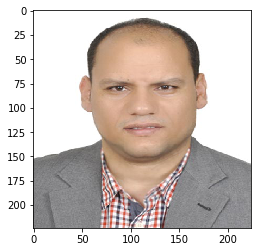

Oh, That's a human there !he looks like  a Glen_of_imaal_terrier



In [72]:
DogBreed('test/YosryNegm.jpg')

I Think the outcomes is some how resonable, and I could say that using ResNet-50 was good option since it gives acceptable accuracy.
- Model could be improved much by <b>extra training</b> with more images.
- Also Data <b>Augumentation</b> could improve the output.
- based on probabilities of a prediction( could be saved ) we determine dog-or-human based due to highest probability of the classification to reduce the  overhead of dog/human detection

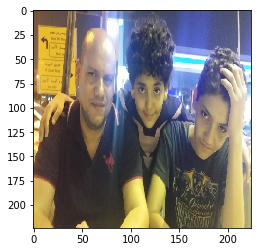

Oh, That's a human there !he looks like  a Dachshund



In [73]:
DogBreed('test/yosryFamily.jpg')

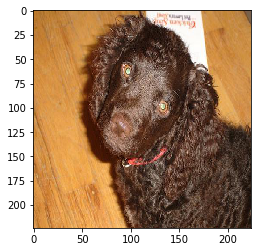

WoW ! There is a dog , and its breed is  American_water_spaniel



In [74]:
DogBreed('test/1.jpg')

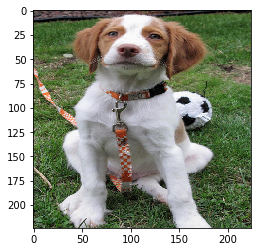

WoW ! There is a dog , and its breed is  Brittany



In [75]:
DogBreed('test/2.jpg')

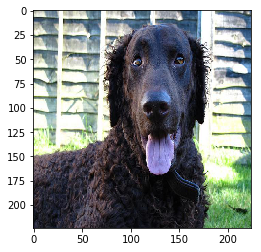

WoW ! There is a dog , and its breed is  Curly-coated_retriever



In [76]:
DogBreed('test/3.jpg')

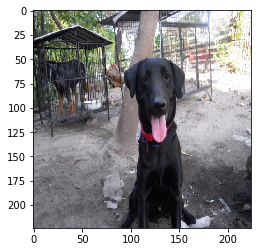

WoW ! There is a dog , and its breed is  Labrador_retriever



In [77]:
DogBreed('test/4.jpg')

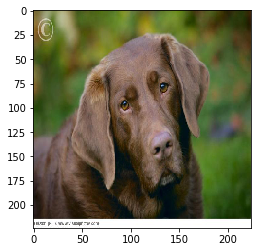

WoW ! There is a dog , and its breed is  Labrador_retriever



In [78]:
DogBreed('test/5.jpg')

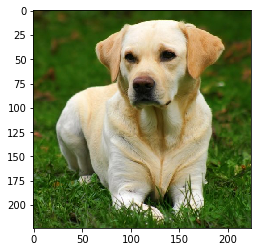

WoW ! There is a dog , and its breed is  Labrador_retriever



In [79]:
DogBreed('test/6.jpg')

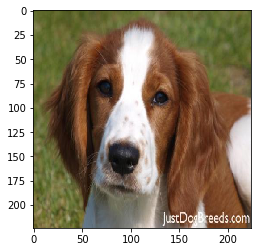

WoW ! There is a dog , and its breed is  Welsh_springer_spaniel



In [80]:
DogBreed('test/7.jpg')

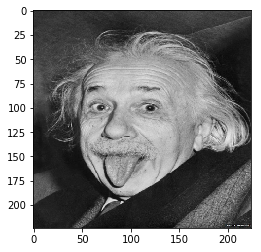

Oh, That's a human there !he looks like  a Dachshund



In [81]:
DogBreed('test/8.jpg')

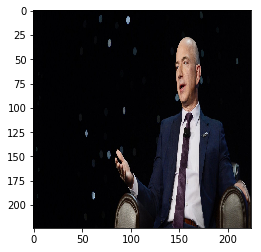

Oh, That's a human there !he looks like  a Petit_basset_griffon_vendeen



In [82]:
DogBreed('test/9.jpg')

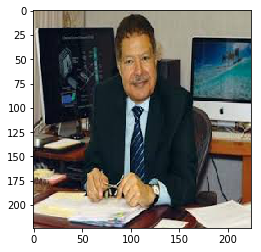

Oh, That's a human there !he looks like  a Dachshund



In [83]:
DogBreed('test/10.jpg')

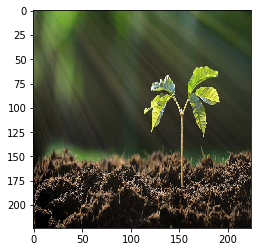

The image contains neither human nor dog.


In [84]:
DogBreed('test/11.jpg')